# Предсказание судебного решения американского верховного суда

В этом проекте я буду решать задачу предсказания судебного решения верховного сула США. По набору известных данных о предстоящем судебном заседании и прочих данных мы будем пресдказывать, каким будет решение суда. 

В этом ноутбуке предоставлен сырой код до рефакторинга.  Здесь проводились все эксперименты с моделями до начала курса. Это - первоисточник будущего проекта, который будет по ходу курса изменяться.

### Импортирование необходимых библиотек

In [5]:
import itertools
import pandas as pd
import chardet  
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import chi2
import h2o
from h2o.estimators import H2ORandomForestEstimator
from itertools import permutations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,37 mins 02 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,2 months and 18 days
H2O_cluster_name:,H2O_from_python_FerventFrost_873lys
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.634 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [6]:
#делаем так чтобы показывались все столбцы, а не только первые и последние
pd.set_option('display.max_columns', None)

В качестве набора данных для решения поставленной задачи я выбрал SCDB (supreme court database) http://supremecourtdatabase.org/ . Она содержит в себе максимально полную и подробную информацию в удобной форме по судебным делам верховного суда США с 1946 года по нынешнее время. 

В качестве начальных признаков  для построения модели машинного обучения я отобрал те признаки из исходного набора данных, которые известны пользователю во время поступления дела в верхлвный суд 

In [7]:
PATH_TO_DATA = r"E:\Work\Projects\Judjement_prediction\Data\SCDB_2021_01_caseCentered_Docket.csv"
df = pd.read_csv(PATH_TO_DATA, encoding = "windows-1252")

In [8]:
df.iloc[1000:1059, :]

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,term,naturalCourt,chief,docket,caseName,dateArgument,dateRearg,petitioner,petitionerState,respondent,respondentState,jurisdiction,adminAction,adminActionState,threeJudgeFdc,caseOrigin,caseOriginState,caseSource,caseSourceState,lcDisagreement,certReason,lcDisposition,lcDispositionDirection,declarationUncon,caseDisposition,caseDispositionUnusual,partyWinning,precedentAlteration,voteUnclear,issue,issueArea,decisionDirection,decisionDirectionDissent,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes
1000,1952-101,1952-101-01,1952-101-01-01,1952-101-01-01-01,6/8/1953,1,346 U.S. 15,73 S. Ct. 956,97 L. Ed. 2d 1427,1953 U.S. LEXIS 2536,1952,1303,Vinson,308,DALEHITE ET AL. v. UNITED STATES,4/6/1953,NaN,208.0,NaN,27.0,NaN,1.0,NaN,NaN,0.0,121.0,51.0,25.0,NaN,0.0,10.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,80060.0,8.0,2.0,0.0,4.0,NaN,3.0,374.0,NaN,79.0,87.0,1,4,3
1001,1952-102,1952-102-01,1952-102-01-01,1952-102-01-01-01,6/8/1953,1,346 U.S. 61,73 S. Ct. 1017,97 L. Ed. 2d 1454,1953 U.S. LEXIS 2687,1952,1303,Vinson,89,AUTOMATIC CANTEEN COMPANY OF AMERICA v. FEDERA...,12/15/1952,NaN,123.0,NaN,357.0,NaN,1.0,57.0,NaN,0.0,27.0,NaN,27.0,NaN,0.0,11.0,2.0,2.0,1.0,4.0,0.0,1.0,0.0,0.0,80010.0,8.0,1.0,0.0,4.0,NaN,3.0,364.0,NaN,80.0,87.0,1,6,3
1002,1952-103,1952-103-01,1952-103-01-01,1952-103-01-01-01,6/8/1953,1,346 U.S. 86,73 S. Ct. 998,97 L. Ed. 2d 1470,1953 U.S. LEXIS 2720,1952,1303,Vinson,567,FEDERAL COMMUNICATIONS COMMISSION v. RCA COMMU...,4/29/1953,NaN,338.0,NaN,221.0,NaN,1.0,38.0,NaN,0.0,32.0,NaN,32.0,NaN,1.0,10.0,8.0,2.0,1.0,5.0,0.0,1.0,0.0,0.0,90120.0,9.0,1.0,0.0,5.0,4.0,3.0,326.0,NaN,80.0,87.0,1,6,1
1003,1952-103,1952-103-02,1952-103-02-01,1952-103-02-01-01,6/8/1953,1,346 U.S. 86,73 S. Ct. 998,97 L. Ed. 2d 1470,1953 U.S. LEXIS 2720,1952,1303,Vinson,568,FEDERAL COMMUNICATIONS COMMISSION v. RCA COMMU...,4/29/1953,NaN,221.0,NaN,221.0,NaN,1.0,38.0,NaN,0.0,32.0,NaN,32.0,NaN,1.0,10.0,8.0,2.0,1.0,5.0,0.0,1.0,0.0,0.0,90120.0,9.0,1.0,0.0,5.0,4.0,3.0,326.0,NaN,80.0,87.0,1,6,1
1004,1952-104,1952-104-01,1952-104-01-01,1952-104-01-01-01,6/8/1953,1,346 U.S. 100,73 S. Ct. 1007,97 L. Ed. 2d 1480,1953 U.S. LEXIS 2001,1952,1303,Vinson,617,"DISTRICT OF COLUMBIA v. JOHN R. THOMPSON CO., ...",4/30/1953,NaN,28.0,10.0,228.0,NaN,1.0,NaN,NaN,0.0,302.0,10.0,32.0,NaN,0.0,12.0,9.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,20040.0,2.0,2.0,0.0,4.0,NaN,3.0,320.0,NaN,81.0,87.0,1,8,0
1005,1952-105,1952-105-01,1952-105-01-01,1952-105-01-01-01,6/8/1953,1,346 U.S. 119,73 S. Ct. 981,97 L. Ed. 2d 1494,1953 U.S. LEXIS 2688,1952,1303,Vinson,512,SECURITIES & EXCHANGE COMMISSION v. RALSTON PU...,4/28/1953,NaN,405.0,NaN,185.0,NaN,1.0,NaN,NaN,0.0,86.0,30.0,28.0,NaN,0.0,11.0,2.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,80120.0,8.0,2.0,0.0,4.0,NaN,3.0,365.0,NaN,88.0,78.0,1,6,2
1006,1952-106,1952-106-01,1952-106-01-01,1952-106-01-01-01,6/8/1953,1,346 U.S. 128,73 S. Ct. 986,97 L. Ed. 2d 1500,1953 U.S. LEXIS 2571,1952,1303,Vinson,525,"NEW YORK, NEW HAVEN & HARTFORD RAILROAD CO. v....",4/29/1953,NaN,231.0,NaN,134.0,NaN,1.0,NaN,NaN,0.0,302.0,8.0,300.0,8.0,0.0,11.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,100030.0,10.0,1.0,0.0,4.0,5.0,3.0,343.0,NaN,88.0,87.0,1,8,0
1007,1952-107,1952-107-01,1952-107-01-01,1952-107-01-01-01,6/15/1953,7,346 U.S. 137,73 S. Ct. 1045,97 L. Ed. 2d 1508,1953 U.S. LEXIS 1900,1952,1303,Vinson,422,"BURNS ET AL. v. WILSON, SECRETARY OF DEFENSE, ...",2/5/1953,NaN,186.0,NaN,324.0,NaN,1.0,NaN,NaN,0.0,55.0,10.0,32.0,NaN,1.0,10.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,10020.0,1.0,1.0,0.0,4.0,NaN,3.0,341.0,NaN,87.0,87.0,1,6,3
1008,1952-108,1952-108-01,1952-108-01-01,1952-108-01-01-01,6/15/1953,1,346 U.S. 156,73 S. Ct. 1077,97 L. Ed. 2d 1522,1953 U.S. LEXIS 1901,1952,1303,Vinson,391,STEIN v. NEW YORK,12/18/1952,NaN,100.0,NaN,28.0,37.0,1.0,NaN,NaN,0.0,302.0,37.0,300.0,37.0,0.0,11.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,10010.0,1.0,1.0,0.0,2.0,NaN,2.0,210.0,NaN,84.0,87.0

Предобрабатываем данные, разбираемся с пропущенными значениями. Позже поэеспериментируем с различными способами заполнения пропусков в данных.

In [9]:
PATH_TO_DATA = "E:\Work\Projects\Judjement_prediction\Data\SCDB_2021_01_caseCentered_Docket.csv"

df = pd.read_csv(PATH_TO_DATA, encoding = "windows-1252")

df_newfe = df[["partyWinning","caseDisposition", "petitionerState", "petitioner", "respondent", "respondentState",
               "jurisdiction", "adminAction", "adminActionState", "caseOrigin", "caseOriginState", "caseSource",
               "caseSourceState", "lcDisposition", "lcDispositionDirection",
               "issueArea", "lawType", "certReason", "lcDisagreement"]]

df_newfe.loc[:, ["petitionerState", "respondentState"]].fillna(0, inplace = True)

df_newfe["petitionerState"].fillna(0, inplace = True)
df_newfe["respondentState"].fillna(0, inplace = True)
df_newfe["caseSourceState"].fillna(0, inplace = True)
df_newfe["adminAction"].fillna(0, inplace = True)
df_newfe["adminActionState"].fillna(0, inplace = True)
df_newfe["caseOriginState"].fillna(0, inplace = True)
df_newfe["caseOrigin"].fillna(0, inplace = True)
df_newfe["caseSource"].fillna(0, inplace = True)
df_newfe["lcDisposition"].fillna(0, inplace = True)
df_newfe["lcDispositionDirection"].fillna(3.0, inplace = True)
df_newfe["issueArea"].fillna(0, inplace = True)
df_newfe["lawType"].fillna(0, inplace = True)
df_newfe["certReason"].fillna(0, inplace = True)
df_newfe["lcDisagreement"].fillna(0, inplace = True)

df_newfe = df_newfe[(df_newfe['partyWinning'].notna() == True) & (df_newfe['partyWinning'] != 2.0)]

df_newfe = df_newfe[(df_newfe['petitioner'].notna()) & (df_newfe['respondent'].notna()) 
                    & (df_newfe['jurisdiction'].notna())]

X = df_newfe[["petitionerState", "petitioner", "respondent", "respondentState",
               "jurisdiction", "adminAction", "adminActionState", "caseOrigin", "caseOriginState", "caseSource",
               "caseSourceState", "lcDisposition", "lcDispositionDirection",
               "issueArea", "lawType", "certReason", "lcDisagreement"]]
enc_X = OneHotEncoder().fit_transform(X).toarray()
y = df_newfe["partyWinning"]

X_train, X_test, y_train, y_test = train_test_split(
        enc_X, y, test_size=0.33, stratify=y, random_state=18)

X_valid_train, X_valid_test, y_valid_train, y_valid_test = train_test_split(
        X_train, y_train, test_size=0.33, stratify=y_train, random_state=18)

e:\programs\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Выбор метрики 

In [10]:
df_newfe["partyWinning"].value_counts()

1.0    6687
0.0    3854
Name: partyWinning, dtype: int64

Так как присутствует дисбаланс классов, но он не очень ярко выражеy, будем применять метрику roc-auc.

## Подбор модели для обучения

Выберем модель, которая будет использоваться для обучения наших данных. 

### Логистическая регрессия

In [15]:
lr = LogisticRegression(random_state=18).fit(X_train, y_train)

e:\programs\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Значение метрики логистической регрессии на тестовой выборке:

In [17]:
y_pred = lr.predict(X_test)
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.6445096434158895

### Случайный лес

In [19]:
clf = RandomForestClassifier(random_state=18)
rf = clf.fit(X_train, y_train)
y_pred_tree = rf.predict(X_test)

Roc auc случайного леса на тестовой выборке:

In [20]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.7191292784821309

### Градиентный бустинг

In [21]:
model = xgb.XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=1000,
                        learning_rate = 0.01, ranadom_state = 18)

In [26]:
model.fit(X_train, y_train)
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

[17:54:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "ranadom_state" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




0.7004846999113741

### Подбор гиперпараметров случайного леса

Случайный лес показал себя наилучшим образом

In [38]:
clf

RandomForestClassifier(random_state=18)

In [39]:
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ranadom_state=18,
              random_state=0, reg_alpha=0, ...)

In [40]:
rf = clf.fit(X_valid_train, y_valid_train)
roc_auc_score(y_valid_test, clf.predict_proba(X_valid_test)[:, 1])

0.7090324797557035

In [34]:
%%time
params = {'max_features': [int(x+1) for x in range(15)],
          'criterion': ["gini", "entropy"],
          'min_samples_split': [2, 5, 10, 100, 600],
          'min_samples_leaf':[1, 5, 10, 200, 500],
          'n_estimators': [80,  120, 500],
          'max_depth': [4, 30, 500, 2000],
          'bootstrap': [True, False]}
RFRSCV = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 18),
                        param_distributions = params,
                        scoring='roc_auc',
                        n_iter=1000,
                        verbose=10, 
                        cv = 3, 
                        return_train_score = True,
                        random_state = 18)
RFRSCV.fit(X_train, y_train)
print("Best parameters:", RFRSCV.best_params_)
print("highest_roc_auc: ", (RFRSCV.best_score_))

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
[CV 1/3; 1/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 1/3; 1/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.564, test=0.528) total time=   0.3s
[CV 2/3; 1/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 2/3; 1/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.537, test=0.544) total time=   0.2s
[CV 3/3; 1/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 3/3; 1/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_feature

[CV 1/3; 9/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500;, score=(train=0.611, test=0.581) total time=   1.0s
[CV 2/3; 9/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500
[CV 2/3; 9/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500;, score=(train=0.596, test=0.595) total time=   1.0s
[CV 3/3; 9/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500
[CV 3/3; 9/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500;, score=(train=0.595, test=0.596) total time=   1.0s
[CV 1/3; 10/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=8, min_samples_leaf=2

[CV 1/3; 17/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.862, test=0.638) total time=   1.2s
[CV 2/3; 17/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 2/3; 17/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.864, test=0.646) total time=   1.2s
[CV 3/3; 17/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 3/3; 17/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.858, test=0.689) total time=   1.2s
[CV 1/3; 18/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=3, min_samples_leaf=1, min_s

[CV 1/3; 25/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.547, test=0.531) total time=   0.2s
[CV 2/3; 25/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120
[CV 2/3; 25/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.542, test=0.543) total time=   0.2s
[CV 3/3; 25/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120
[CV 3/3; 25/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.537, test=0.553) total time=   0.2s
[CV 1/3; 26/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=5, min_s

[CV 1/3; 33/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.731, test=0.635) total time=   6.7s
[CV 2/3; 33/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 2/3; 33/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.742, test=0.655) total time=   7.0s
[CV 3/3; 33/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 3/3; 33/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.730, test=0.679) total time=   6.6s
[CV 1/3; 34/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_

[CV 1/3; 41/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.609, test=0.557) total time=   0.3s
[CV 2/3; 41/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 2/3; 41/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.592, test=0.594) total time=   0.2s
[CV 3/3; 41/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 3/3; 41/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.582, test=0.595) total time=   0.2s
[CV 1/3; 42/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=3, min_samples_leaf

[CV 1/3; 49/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.588, test=0.553) total time=   0.2s
[CV 2/3; 49/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80
[CV 2/3; 49/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.565, test=0.572) total time=   0.2s
[CV 3/3; 49/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80
[CV 3/3; 49/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.563, test=0.581) total time=   0.2s
[CV 1/3; 50/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=13

[CV 1/3; 57/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.594, test=0.548) total time=   0.2s
[CV 2/3; 57/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80
[CV 2/3; 57/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.586, test=0.587) total time=   0.2s
[CV 3/3; 57/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80
[CV 3/3; 57/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.594, test=0.602) total time=   0.2s
[CV 1/3; 58/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=4, min_samples_leaf=500, mi

[CV 1/3; 65/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.612, test=0.556) total time=   0.2s
[CV 2/3; 65/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 2/3; 65/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.599, test=0.606) total time=   0.2s
[CV 3/3; 65/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 3/3; 65/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.590, test=0.591) total time=   0.2s
[CV 1/3; 66/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=200, min_samp

[CV 1/3; 73/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.597, test=0.554) total time=   0.3s
[CV 2/3; 73/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120
[CV 2/3; 73/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.562, test=0.561) total time=   0.3s
[CV 3/3; 73/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120
[CV 3/3; 73/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.564, test=0.574) total time=   0.3s
[CV 1/3; 74/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf

[CV 1/3; 81/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.618, test=0.589) total time=   1.0s
[CV 2/3; 81/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 2/3; 81/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.611, test=0.604) total time=   1.0s
[CV 3/3; 81/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 3/3; 81/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.603, test=0.605) total time=   1.0s
[CV 1/3; 82/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=9, min_samples_leaf=10, min_samp

[CV 1/3; 89/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500;, score=(train=0.583, test=0.568) total time=   1.4s
[CV 2/3; 89/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500
[CV 2/3; 89/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500;, score=(train=0.577, test=0.581) total time=   1.3s
[CV 3/3; 89/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500
[CV 3/3; 89/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500;, score=(train=0.574, test=0.572) total time=   1.3s
[CV 1/3; 90/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=11, min_sampl

[CV 1/3; 97/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.710, test=0.622) total time=   1.7s
[CV 2/3; 97/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500
[CV 2/3; 97/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.718, test=0.635) total time=   1.7s
[CV 3/3; 97/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500
[CV 3/3; 97/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.704, test=0.660) total time=   1.7s
[CV 1/3; 98/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=200, min_samples_

[CV 1/3; 105/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.724, test=0.626) total time=   0.9s
[CV 2/3; 105/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 2/3; 105/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.735, test=0.651) total time=   0.9s
[CV 3/3; 105/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 3/3; 105/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.720, test=0.675) total time=   0.8s
[CV 1/3; 106/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=12

[CV 1/3; 113/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.712, test=0.628) total time=   0.9s
[CV 2/3; 113/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 113/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.721, test=0.650) total time=   2.6s
[CV 3/3; 113/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 113/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.708, test=0.665) total time=   0.9s
[CV 1/3; 114/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=15, min_samples_leaf=1,

[CV 1/3; 121/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.759, test=0.640) total time=  10.9s
[CV 2/3; 121/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500
[CV 2/3; 121/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.766, test=0.657) total time=   8.3s
[CV 3/3; 121/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500
[CV 3/3; 121/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.760, test=0.683) total time=   8.9s
[CV 1/3; 122/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=200, min_

[CV 1/3; 129/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.585, test=0.551) total time=   0.3s
[CV 2/3; 129/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120
[CV 2/3; 129/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.565, test=0.564) total time=   0.4s
[CV 3/3; 129/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120
[CV 3/3; 129/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.574, test=0.575) total time=   0.4s
[CV 1/3; 130/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samp

[CV 1/3; 137/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120;, score=(train=0.622, test=0.580) total time=   0.4s
[CV 2/3; 137/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120
[CV 2/3; 137/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120;, score=(train=0.607, test=0.601) total time=   0.4s
[CV 3/3; 137/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120
[CV 3/3; 137/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120;, score=(train=0.604, test=0.609) total time=   0.4s
[CV 1/3; 138/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=5, min

[CV 1/3; 145/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.644, test=0.577) total time=   0.2s
[CV 2/3; 145/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 145/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.640, test=0.603) total time=   0.2s
[CV 3/3; 145/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 145/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.626, test=0.621) total time=   0.2s
[CV 1/3; 146/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_le

[CV 1/3; 153/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.695, test=0.614) total time=   0.5s
[CV 2/3; 153/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 2/3; 153/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.706, test=0.640) total time=   0.5s
[CV 3/3; 153/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 3/3; 153/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.691, test=0.661) total time=   0.5s
[CV 1/3; 154/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samp

[CV 1/3; 161/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.601, test=0.562) total time=   0.3s
[CV 2/3; 161/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 2/3; 161/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.593, test=0.597) total time=   0.4s
[CV 3/3; 161/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 3/3; 161/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.583, test=0.608) total time=   0.3s
[CV 1/3; 162/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features

[CV 1/3; 169/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.685, test=0.569) total time=   0.5s
[CV 2/3; 169/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 2/3; 169/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.684, test=0.605) total time=   0.4s
[CV 3/3; 169/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 3/3; 169/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.673, test=0.641) total time=   0.3s
[CV 1/3; 170/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=3, min_samples_le

[CV 1/3; 177/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.997, test=0.693) total time=   3.2s
[CV 2/3; 177/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 2/3; 177/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.998, test=0.694) total time=   2.9s
[CV 3/3; 177/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 3/3; 177/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.997, test=0.704) total time=   2.8s
[CV 1/3; 178/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=8, min_samples_leaf=5, min_sampl

[CV 1/3; 185/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.999, test=0.686) total time=   2.9s
[CV 2/3; 185/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 2/3; 185/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=1.000, test=0.691) total time=   2.8s
[CV 3/3; 185/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 3/3; 185/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.999, test=0.703) total time=   2.7s
[CV 1/3; 186/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=3, min_sample

[CV 1/3; 193/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.713, test=0.616) total time=   0.4s
[CV 2/3; 193/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 2/3; 193/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.722, test=0.638) total time=   0.4s
[CV 3/3; 193/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 3/3; 193/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.718, test=0.670) total time=   0.4s
[CV 1/3; 194/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=5, min_

[CV 1/3; 201/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.696, test=0.625) total time=   0.8s
[CV 2/3; 201/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120
[CV 2/3; 201/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.697, test=0.638) total time=   0.8s
[CV 3/3; 201/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120
[CV 3/3; 201/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.685, test=0.648) total time=   0.7s
[CV 1/3; 202/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=12, m

[CV 1/3; 209/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.690, test=0.620) total time=   0.4s
[CV 2/3; 209/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 209/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.694, test=0.648) total time=   0.4s
[CV 3/3; 209/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 209/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.681, test=0.654) total time=   0.4s
[CV 1/3; 210/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_s

[CV 1/3; 217/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80;, score=(train=0.914, test=0.653) total time=   1.7s
[CV 2/3; 217/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80
[CV 2/3; 217/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80;, score=(train=0.916, test=0.675) total time=   1.5s
[CV 3/3; 217/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80
[CV 3/3; 217/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80;, score=(train=0.914, test=0.693) total time=   1.5s
[CV 1/3; 218/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=200, 

[CV 1/3; 225/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.624, test=0.547) total time=   0.2s
[CV 2/3; 225/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 225/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.632, test=0.585) total time=   0.2s
[CV 3/3; 225/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 225/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.593, test=0.619) total time=   0.2s
[CV 1/3; 226/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_

[CV 1/3; 233/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=(train=0.915, test=0.647) total time=   1.0s
[CV 2/3; 233/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120
[CV 2/3; 233/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=(train=0.925, test=0.667) total time=   1.0s
[CV 3/3; 233/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120
[CV 3/3; 233/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=(train=0.917, test=0.688) total time=   1.0s
[CV 1/3; 234/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_le

[CV 1/3; 241/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.733, test=0.638) total time=   8.0s
[CV 2/3; 241/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 2/3; 241/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.743, test=0.654) total time=   8.2s
[CV 3/3; 241/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 3/3; 241/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.730, test=0.676) total time=   7.8s
[CV 1/3; 242/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=14, min_samples

[CV 1/3; 249/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.709, test=0.620) total time=   0.7s
[CV 2/3; 249/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 2/3; 249/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.714, test=0.636) total time=   0.7s
[CV 3/3; 249/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 3/3; 249/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.705, test=0.663) total time=   0.7s
[CV 1/3; 250/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=13, min_samples_leaf=200

[CV 1/3; 257/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80;, score=(train=0.729, test=0.629) total time=   1.0s
[CV 2/3; 257/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80
[CV 2/3; 257/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80;, score=(train=0.739, test=0.648) total time=   1.0s
[CV 3/3; 257/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80
[CV 3/3; 257/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80;, score=(train=0.733, test=0.669) total time=   1.1s
[CV 1/3; 258/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=4, min_samples_leaf

[CV 1/3; 265/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80;, score=(train=0.791, test=0.645) total time=   2.1s
[CV 2/3; 265/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80
[CV 2/3; 265/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80;, score=(train=0.795, test=0.655) total time=   2.2s
[CV 3/3; 265/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80
[CV 3/3; 265/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80;, score=(train=0.793, test=0.681) total time=   2.1s
[CV 1/3; 266/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=2, min_samples_le

[CV 1/3; 273/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120;, score=(train=0.702, test=0.622) total time=   0.5s
[CV 2/3; 273/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120
[CV 2/3; 273/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120;, score=(train=0.710, test=0.630) total time=   0.5s
[CV 3/3; 273/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120
[CV 3/3; 273/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120;, score=(train=0.701, test=0.660) total time=   0.6s
[CV 1/3; 274/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=2, min_samples_leaf=10, min_s

[CV 1/3; 281/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.590, test=0.565) total time=   1.8s
[CV 2/3; 281/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500
[CV 2/3; 281/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.578, test=0.582) total time=   1.6s
[CV 3/3; 281/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500
[CV 3/3; 281/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.575, test=0.571) total time=   1.5s
[CV 1/3; 282/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=200,

[CV 1/3; 289/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500;, score=(train=0.618, test=0.582) total time=   1.7s
[CV 2/3; 289/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500
[CV 2/3; 289/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500;, score=(train=0.610, test=0.609) total time=   1.7s
[CV 3/3; 289/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500
[CV 3/3; 289/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500;, score=(train=0.607, test=0.613) total time=   1.7s
[CV 1/3; 290/1000] START bootstrap=True, criterion=gini, max_depth=500, max_f

[CV 1/3; 297/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80;, score=(train=0.688, test=0.607) total time=   0.3s
[CV 2/3; 297/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80
[CV 2/3; 297/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80;, score=(train=0.690, test=0.626) total time=   0.3s
[CV 3/3; 297/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80
[CV 3/3; 297/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80;, score=(train=0.675, test=0.656) total time=   0.3s
[CV 1/3; 298/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, 

[CV 1/3; 305/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.604, test=0.555) total time=   0.2s
[CV 2/3; 305/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80
[CV 2/3; 305/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.572, test=0.573) total time=   0.2s
[CV 3/3; 305/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80
[CV 3/3; 305/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.587, test=0.602) total time=   0.2s
[CV 1/3; 306/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=7, 

[CV 1/3; 313/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.637, test=0.568) total time=   0.2s
[CV 2/3; 313/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 2/3; 313/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.626, test=0.588) total time=   0.2s
[CV 3/3; 313/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 3/3; 313/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.617, test=0.611) total time=   0.2s
[CV 1/3; 314/1000] START bootstrap=False, criterion=entropy, max_depth=500, m

[CV 1/3; 321/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.997, test=0.681) total time=   1.8s
[CV 2/3; 321/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 2/3; 321/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.998, test=0.691) total time=   1.7s
[CV 3/3; 321/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 3/3; 321/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.997, test=0.706) total time=   1.9s
[CV 1/3; 322/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=10, min_s

[CV 1/3; 329/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.548, test=0.530) total time=   0.2s
[CV 2/3; 329/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 2/3; 329/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.542, test=0.543) total time=   0.2s
[CV 3/3; 329/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 3/3; 329/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.537, test=0.553) total time=   0.2s
[CV 1/3; 330/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=4, 

[CV 1/3; 337/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.740, test=0.637) total time=  10.6s
[CV 2/3; 337/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 2/3; 337/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.749, test=0.657) total time=  10.7s
[CV 3/3; 337/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 3/3; 337/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.737, test=0.680) total time=  10.3s
[CV 1/3; 338/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=3, min_samples

[CV 1/3; 345/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500;, score=(train=0.964, test=0.680) total time=  20.9s
[CV 2/3; 345/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500
[CV 2/3; 345/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500;, score=(train=0.965, test=0.683) total time=  21.0s
[CV 3/3; 345/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500
[CV 3/3; 345/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500;, score=(train=0.968, test=0.706) total time=  21.0s
[CV 1/3; 346/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=1, min_sample

[CV 1/3; 353/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120;, score=(train=0.616, test=0.579) total time=   0.4s
[CV 2/3; 353/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120
[CV 2/3; 353/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120;, score=(train=0.599, test=0.602) total time=   0.4s
[CV 3/3; 353/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120
[CV 3/3; 353/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120;, score=(train=0.592, test=0.600) total time=   0.4s
[CV 1/3; 354/1000] START bootstrap=True, criterion=gini, max_depth=500, max_featur

[CV 1/3; 361/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.584, test=0.566) total time=   1.4s
[CV 2/3; 361/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 2/3; 361/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.575, test=0.581) total time=   1.4s
[CV 3/3; 361/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 3/3; 361/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.576, test=0.576) total time=   1.4s
[CV 1/3; 362/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=5, min_samp

[CV 1/3; 369/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500;, score=(train=0.701, test=0.618) total time=   2.1s
[CV 2/3; 369/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500
[CV 2/3; 369/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500;, score=(train=0.711, test=0.645) total time=   2.0s
[CV 3/3; 369/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500
[CV 3/3; 369/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500;, score=(train=0.696, test=0.664) total time=   2.0s
[CV 1/3; 370/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=13, min_sam

[CV 1/3; 377/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.564, test=0.532) total time=   0.2s
[CV 2/3; 377/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 2/3; 377/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.554, test=0.557) total time=   0.2s
[CV 3/3; 377/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 3/3; 377/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.543, test=0.573) total time=   0.2s
[CV 1/3; 378/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=3, min_samples_l

[CV 1/3; 385/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120;, score=(train=0.579, test=0.548) total time=   0.3s
[CV 2/3; 385/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120
[CV 2/3; 385/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120;, score=(train=0.567, test=0.573) total time=   0.3s
[CV 3/3; 385/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120
[CV 3/3; 385/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120;, score=(train=0.557, test=0.587) total time=   0.3s
[CV 1/3; 386/1000] START bootstrap=True, criterion=gini, max_depth=4, max_fea

[CV 1/3; 393/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.691, test=0.598) total time=   0.4s
[CV 2/3; 393/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120
[CV 2/3; 393/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.701, test=0.634) total time=   0.4s
[CV 3/3; 393/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120
[CV 3/3; 393/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.678, test=0.655) total time=   0.4s
[CV 1/3; 394/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=11

[CV 1/3; 401/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.524, test=0.512) total time=   0.2s
[CV 2/3; 401/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80
[CV 2/3; 401/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.517, test=0.528) total time=   0.2s
[CV 3/3; 401/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80
[CV 3/3; 401/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.520, test=0.521) total time=   0.2s
[CV 1/3; 402/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=4, min_samples_leaf=200, min_s

[CV 1/3; 409/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.600, test=0.572) total time=   1.1s
[CV 2/3; 409/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500
[CV 2/3; 409/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.585, test=0.591) total time=   1.1s
[CV 3/3; 409/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500
[CV 3/3; 409/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.586, test=0.584) total time=   1.1s
[CV 1/3; 410/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min

[CV 1/3; 417/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=(train=0.992, test=0.686) total time=  11.9s
[CV 2/3; 417/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500
[CV 2/3; 417/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=(train=0.994, test=0.699) total time=  11.9s
[CV 3/3; 417/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500
[CV 3/3; 417/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=(train=0.993, test=0.714) total time=  12.1s
[CV 1/3; 418/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=200, m

[CV 1/3; 425/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.715, test=0.613) total time=   0.4s
[CV 2/3; 425/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120
[CV 2/3; 425/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.725, test=0.637) total time=   0.4s
[CV 3/3; 425/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120
[CV 3/3; 425/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.701, test=0.659) total time=   0.4s
[CV 1/3; 426/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=13, min_sample

[CV 1/3; 433/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.611, test=0.565) total time=   0.4s
[CV 2/3; 433/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 2/3; 433/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.594, test=0.581) total time=   0.3s
[CV 3/3; 433/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 3/3; 433/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.591, test=0.597) total time=   0.3s
[CV 1/3; 434/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=4, min_sa

[CV 1/3; 441/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.992, test=0.681) total time=   2.4s
[CV 2/3; 441/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 2/3; 441/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.992, test=0.693) total time=   2.5s
[CV 3/3; 441/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 3/3; 441/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.992, test=0.705) total time=   2.6s
[CV 1/3; 442/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_

[CV 1/3; 449/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.790, test=0.642) total time=   2.2s
[CV 2/3; 449/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120
[CV 2/3; 449/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.801, test=0.656) total time=   2.3s
[CV 3/3; 449/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120
[CV 3/3; 449/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.791, test=0.683) total time=   2.2s
[CV 1/3; 450/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_sample

[CV 1/3; 457/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500;, score=(train=0.612, test=0.578) total time=   1.4s
[CV 2/3; 457/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500
[CV 2/3; 457/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500;, score=(train=0.598, test=0.602) total time=   1.3s
[CV 3/3; 457/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500
[CV 3/3; 457/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500;, score=(train=0.593, test=0.593) total time=   3.1s
[CV 1/3; 458/1000] START bootstrap=False, criterion=gini, max_depth

[CV 1/3; 465/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.690, test=0.620) total time=   0.4s
[CV 2/3; 465/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80
[CV 2/3; 465/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.694, test=0.648) total time=   0.4s
[CV 3/3; 465/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80
[CV 3/3; 465/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.681, test=0.654) total time=   0.4s
[CV 1/3; 466/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=4, min_samples_leaf=500, min_

[CV 1/3; 473/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.855, test=0.652) total time=  13.5s
[CV 2/3; 473/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 2/3; 473/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.864, test=0.666) total time=  14.0s
[CV 3/3; 473/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 3/3; 473/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.859, test=0.696) total time=  13.9s
[CV 1/3; 474/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=9,

[CV 1/3; 481/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.850, test=0.655) total time=   3.6s
[CV 2/3; 481/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120
[CV 2/3; 481/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.853, test=0.663) total time=   3.7s
[CV 3/3; 481/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120
[CV 3/3; 481/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.858, test=0.692) total time=   3.8s
[CV 1/3; 482/1000] START bootstrap=False, criterion=gini, max_depth=500, max_featu

[CV 1/3; 489/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.702, test=0.613) total time=   1.7s
[CV 2/3; 489/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500
[CV 2/3; 489/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.710, test=0.633) total time=   1.6s
[CV 3/3; 489/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500
[CV 3/3; 489/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.699, test=0.642) total time=   1.6s
[CV 1/3; 490/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=10, min_sampl

[CV 1/3; 497/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500;, score=(train=0.650, test=0.599) total time=   1.2s
[CV 2/3; 497/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500
[CV 2/3; 497/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500;, score=(train=0.657, test=0.606) total time=   1.3s
[CV 3/3; 497/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500
[CV 3/3; 497/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500;, score=(train=0.655, test=0.618) total time=   1.3s
[CV 1/3; 498/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=200

[CV 1/3; 505/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.707, test=0.607) total time=   0.9s
[CV 2/3; 505/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120
[CV 2/3; 505/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.714, test=0.641) total time=   0.7s
[CV 3/3; 505/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120
[CV 3/3; 505/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.695, test=0.654) total time=   0.7s
[CV 1/3; 506/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=200

[CV 1/3; 513/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.701, test=0.627) total time=   0.7s
[CV 2/3; 513/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 513/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.700, test=0.641) total time=   0.7s
[CV 3/3; 513/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 513/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.690, test=0.671) total time=   0.8s
[CV 1/3; 514/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=1,

[CV 1/3; 521/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120;, score=(train=0.585, test=0.561) total time=   0.3s
[CV 2/3; 521/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120
[CV 2/3; 521/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120;, score=(train=0.567, test=0.567) total time=   0.3s
[CV 3/3; 521/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120
[CV 3/3; 521/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120;, score=(train=0.573, test=0.591) total time=   0.3s
[CV 1/3; 522/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=4,

[CV 1/3; 529/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.625, test=0.586) total time=   1.5s
[CV 2/3; 529/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 2/3; 529/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.617, test=0.612) total time=   1.6s
[CV 3/3; 529/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 3/3; 529/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.606, test=0.611) total time=   1.7s
[CV 1/3; 530/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=5, m

[CV 1/3; 537/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.698, test=0.627) total time=   1.1s
[CV 2/3; 537/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 2/3; 537/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.706, test=0.644) total time=   1.1s
[CV 3/3; 537/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 3/3; 537/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.698, test=0.668) total time=   1.0s
[CV 1/3; 538/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=1, mi

[CV 1/3; 545/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=(train=0.991, test=0.654) total time=   0.8s
[CV 2/3; 545/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/3; 545/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=(train=0.991, test=0.665) total time=   0.7s
[CV 3/3; 545/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/3; 545/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=(train=0.991, test=0.673) total time=   0.7s
[CV 1/3; 546/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=2, min_samples_leaf=200, mi

[CV 1/3; 553/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.818, test=0.646) total time=   7.7s
[CV 2/3; 553/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 2/3; 553/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.826, test=0.659) total time=   8.0s
[CV 3/3; 553/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 3/3; 553/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.818, test=0.685) total time=   7.9s
[CV 1/3; 554/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=13, 

[CV 1/3; 561/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120;, score=(train=0.706, test=0.627) total time=   1.0s
[CV 2/3; 561/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120
[CV 2/3; 561/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120;, score=(train=0.710, test=0.649) total time=   0.9s
[CV 3/3; 561/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120
[CV 3/3; 561/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120;, score=(train=0.703, test=0.674) total time=   1.0s
[CV 1/3; 562/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=1, m

[CV 1/3; 569/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.570, test=0.542) total time=   0.3s
[CV 2/3; 569/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80
[CV 2/3; 569/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.554, test=0.555) total time=   0.3s
[CV 3/3; 569/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80
[CV 3/3; 569/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.558, test=0.572) total time=   0.3s
[CV 1/3; 570/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=500

[CV 1/3; 577/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.570, test=0.543) total time=   0.2s
[CV 2/3; 577/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 2/3; 577/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.558, test=0.559) total time=   0.2s
[CV 3/3; 577/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 3/3; 577/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.558, test=0.580) total time=   0.2s
[CV 1/3; 578/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=15, min_

[CV 1/3; 585/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.584, test=0.568) total time=   1.6s
[CV 2/3; 585/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500
[CV 2/3; 585/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.573, test=0.578) total time=   1.5s
[CV 3/3; 585/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500
[CV 3/3; 585/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.574, test=0.573) total time=   1.5s
[CV 1/3; 586/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples

[CV 1/3; 593/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.614, test=0.562) total time=   0.3s
[CV 2/3; 593/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 2/3; 593/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.613, test=0.591) total time=   0.3s
[CV 3/3; 593/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 3/3; 593/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.597, test=0.604) total time=   0.3s
[CV 1/3; 594/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=13, m

[CV 1/3; 601/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.753, test=0.637) total time=   6.4s
[CV 2/3; 601/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 2/3; 601/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.765, test=0.657) total time=   6.4s
[CV 3/3; 601/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 3/3; 601/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.753, test=0.681) total time=   6.1s
[CV 1/3; 602/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=5, mi

[CV 1/3; 609/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.680, test=0.617) total time=   0.7s
[CV 2/3; 609/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120
[CV 2/3; 609/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.687, test=0.637) total time=   0.7s
[CV 3/3; 609/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120
[CV 3/3; 609/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.675, test=0.663) total time=   0.7s
[CV 1/3; 610/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=12, mi

[CV 1/3; 617/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.613, test=0.552) total time=   0.2s
[CV 2/3; 617/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 2/3; 617/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.602, test=0.576) total time=   0.2s
[CV 3/3; 617/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 3/3; 617/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.581, test=0.596) total time=   0.3s
[CV 1/3; 618/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=1, min_samples_lea

[CV 1/3; 625/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.655, test=0.566) total time=   0.3s
[CV 2/3; 625/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120
[CV 2/3; 625/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.663, test=0.599) total time=   0.3s
[CV 3/3; 625/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120
[CV 3/3; 625/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.643, test=0.630) total time=   0.3s
[CV 1/3; 626/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=6, 

[CV 1/3; 633/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.604, test=0.555) total time=   0.3s
[CV 2/3; 633/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 2/3; 633/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.600, test=0.600) total time=   0.3s
[CV 3/3; 633/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 3/3; 633/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.585, test=0.593) total time=   0.3s
[CV 1/3; 634/1000] START bootstrap=True, criterion=gini, max_depth=500, max_f

[CV 1/3; 641/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.691, test=0.625) total time=   2.8s
[CV 2/3; 641/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 2/3; 641/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.700, test=0.644) total time=   2.8s
[CV 3/3; 641/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 3/3; 641/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.688, test=0.664) total time=   2.8s
[CV 1/3; 642/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=200, mi

[CV 1/3; 649/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.576, test=0.556) total time=   0.3s
[CV 2/3; 649/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 2/3; 649/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.564, test=0.564) total time=   0.2s
[CV 3/3; 649/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 3/3; 649/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.558, test=0.579) total time=   0.2s
[CV 1/3; 650/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=5,

[CV 1/3; 657/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.792, test=0.649) total time=  14.7s
[CV 2/3; 657/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 2/3; 657/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.804, test=0.662) total time=  13.8s
[CV 3/3; 657/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 3/3; 657/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.793, test=0.685) total time=  16.6s
[CV 1/3; 658/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=1, m

[CV 1/3; 665/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.608, test=0.558) total time=   0.4s
[CV 2/3; 665/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 2/3; 665/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.599, test=0.588) total time=   0.4s
[CV 3/3; 665/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 3/3; 665/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.590, test=0.591) total time=   0.4s
[CV 1/3; 666/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=3, m

[CV 1/3; 673/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.801, test=0.636) total time=   1.8s
[CV 2/3; 673/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 2/3; 673/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.808, test=0.655) total time=   1.9s
[CV 3/3; 673/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 3/3; 673/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.796, test=0.683) total time=   1.8s
[CV 1/3; 674/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=3, min_

[CV 1/3; 681/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.744, test=0.623) total time=   1.7s
[CV 2/3; 681/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 2/3; 681/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.754, test=0.636) total time=   1.8s
[CV 3/3; 681/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 3/3; 681/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.736, test=0.661) total time=   1.7s
[CV 1/3; 682/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=9, min

[CV 1/3; 689/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.703, test=0.624) total time=   1.1s
[CV 2/3; 689/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 689/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.709, test=0.649) total time=   1.5s
[CV 3/3; 689/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 689/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.697, test=0.661) total time=   1.3s
[CV 1/3; 690/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_le

[CV 1/3; 697/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.585, test=0.560) total time=   0.3s
[CV 2/3; 697/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 2/3; 697/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.573, test=0.574) total time=   0.3s
[CV 3/3; 697/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 3/3; 697/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.567, test=0.589) total time=   0.3s
[CV 1/3; 698/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=12, min_samples

[CV 1/3; 705/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.581, test=0.548) total time=   0.4s
[CV 2/3; 705/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80
[CV 2/3; 705/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.564, test=0.573) total time=   0.3s
[CV 3/3; 705/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80
[CV 3/3; 705/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.558, test=0.535) total time=   0.3s
[CV 1/3; 706/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_s

[CV 1/3; 713/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80;, score=(train=0.524, test=0.512) total time=   0.2s
[CV 2/3; 713/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80
[CV 2/3; 713/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80;, score=(train=0.517, test=0.528) total time=   0.3s
[CV 3/3; 713/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80
[CV 3/3; 713/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80;, score=(train=0.520, test=0.521) total time=   0.2s
[CV 1/3; 714/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_lea

[CV 1/3; 721/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.614, test=0.558) total time=   0.3s
[CV 2/3; 721/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 2/3; 721/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.587, test=0.588) total time=   0.3s
[CV 3/3; 721/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 3/3; 721/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.590, test=0.600) total time=   0.3s
[CV 1/3; 722/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_

[CV 1/3; 729/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.580, test=0.557) total time=   0.4s
[CV 2/3; 729/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120
[CV 2/3; 729/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.571, test=0.568) total time=   0.4s
[CV 3/3; 729/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120
[CV 3/3; 729/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.569, test=0.574) total time=   0.4s
[CV 1/3; 730/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=11, min_sample

[CV 1/3; 737/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.683, test=0.602) total time=   0.5s
[CV 2/3; 737/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 737/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.686, test=0.638) total time=   0.4s
[CV 3/3; 737/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 737/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.679, test=0.650) total time=   0.4s
[CV 1/3; 738/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=15, 

[CV 1/3; 745/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=1.000, test=0.698) total time=  19.1s
[CV 2/3; 745/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 2/3; 745/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=1.000, test=0.698) total time=  19.5s
[CV 3/3; 745/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 3/3; 745/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=1.000, test=0.705) total time=  18.4s
[CV 1/3; 746/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=15, min_s

[CV 1/3; 753/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.611, test=0.581) total time=   1.1s
[CV 2/3; 753/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 2/3; 753/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.596, test=0.595) total time=   1.3s
[CV 3/3; 753/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 3/3; 753/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.595, test=0.596) total time=   1.1s
[CV 1/3; 754/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_

[CV 1/3; 761/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=(train=0.796, test=0.650) total time=   2.1s
[CV 2/3; 761/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80
[CV 2/3; 761/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=(train=0.813, test=0.660) total time=   2.4s
[CV 3/3; 761/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80
[CV 3/3; 761/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=(train=0.803, test=0.683) total time=   2.4s
[CV 1/3; 762/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=500, 

[CV 1/3; 769/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.732, test=0.629) total time=   2.2s
[CV 2/3; 769/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120
[CV 2/3; 769/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.739, test=0.654) total time=   2.4s
[CV 3/3; 769/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120
[CV 3/3; 769/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.725, test=0.674) total time=   2.2s
[CV 1/3; 770/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, 

[CV 1/3; 777/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.801, test=0.636) total time=   4.9s
[CV 2/3; 777/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 2/3; 777/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.808, test=0.647) total time=   4.5s
[CV 3/3; 777/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 3/3; 777/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.795, test=0.681) total time=   4.6s
[CV 1/3; 778/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=2, min_samples_leaf=50

[CV 1/3; 785/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80;, score=(train=0.608, test=0.551) total time=   0.3s
[CV 2/3; 785/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80
[CV 2/3; 785/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80;, score=(train=0.584, test=0.597) total time=   0.3s
[CV 3/3; 785/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80
[CV 3/3; 785/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80;, score=(train=0.580, test=0.589) total time=   0.3s
[CV 1/3; 786/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features

[CV 1/3; 793/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120;, score=(train=0.585, test=0.561) total time=   0.2s
[CV 2/3; 793/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120
[CV 2/3; 793/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120;, score=(train=0.567, test=0.567) total time=   0.2s
[CV 3/3; 793/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120
[CV 3/3; 793/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120;, score=(train=0.573, test=0.591) total time=   0.2s
[CV 1/3; 794/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=1, m

[CV 1/3; 801/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.696, test=0.608) total time=   0.3s
[CV 2/3; 801/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 2/3; 801/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.706, test=0.628) total time=   0.3s
[CV 3/3; 801/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 3/3; 801/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.690, test=0.637) total time=   0.3s
[CV 1/3; 802/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=5

[CV 1/3; 809/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.593, test=0.560) total time=   0.3s
[CV 2/3; 809/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 2/3; 809/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.577, test=0.580) total time=   0.4s
[CV 3/3; 809/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 3/3; 809/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.579, test=0.588) total time=   0.3s
[CV 1/3; 810/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samp

[CV 1/3; 817/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.730, test=0.628) total time=   2.2s
[CV 2/3; 817/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 817/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.739, test=0.657) total time=   1.8s
[CV 3/3; 817/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 817/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.729, test=0.675) total time=   1.6s
[CV 1/3; 818/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=11, min_sam

[CV 1/3; 825/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.763, test=0.637) total time=   4.4s
[CV 2/3; 825/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 2/3; 825/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.772, test=0.652) total time=   4.8s
[CV 3/3; 825/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 3/3; 825/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.757, test=0.669) total time=   4.3s
[CV 1/3; 826/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=3, min_samples_le

[CV 1/3; 833/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80;, score=(train=0.705, test=0.600) total time=   0.4s
[CV 2/3; 833/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80
[CV 2/3; 833/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80;, score=(train=0.721, test=0.640) total time=   0.5s
[CV 3/3; 833/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80
[CV 3/3; 833/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80;, score=(train=0.711, test=0.664) total time=   0.5s
[CV 1/3; 834/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=15, min_samples_leaf=10, m

[CV 1/3; 841/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.697, test=0.628) total time=   0.7s
[CV 2/3; 841/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 2/3; 841/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.706, test=0.645) total time=   0.7s
[CV 3/3; 841/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 3/3; 841/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.701, test=0.668) total time=   0.7s
[CV 1/3; 842/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=

[CV 1/3; 849/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.524, test=0.512) total time=   0.3s
[CV 2/3; 849/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80
[CV 2/3; 849/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.517, test=0.528) total time=   0.2s
[CV 3/3; 849/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80
[CV 3/3; 849/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.520, test=0.521) total time=   0.2s
[CV 1/3; 850/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_feature

[CV 1/3; 857/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.639, test=0.563) total time=   0.3s
[CV 2/3; 857/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120
[CV 2/3; 857/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.637, test=0.586) total time=   0.3s
[CV 3/3; 857/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120
[CV 3/3; 857/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.608, test=0.600) total time=   0.3s
[CV 1/3; 858/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=7, min_samples_

[CV 1/3; 865/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=(train=1.000, test=0.677) total time=   5.3s
[CV 2/3; 865/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 2/3; 865/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=(train=1.000, test=0.679) total time=   5.0s
[CV 3/3; 865/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 3/3; 865/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=(train=1.000, test=0.692) total time=   5.0s
[CV 1/3; 866/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=2, min_samples_leaf=200, min

[CV 1/3; 873/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.588, test=0.553) total time=   0.4s
[CV 2/3; 873/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80
[CV 2/3; 873/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.565, test=0.572) total time=   0.2s
[CV 3/3; 873/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80
[CV 3/3; 873/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.563, test=0.581) total time=   0.2s
[CV 1/3; 874/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_sampl

[CV 1/3; 881/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.685, test=0.605) total time=   0.5s
[CV 2/3; 881/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 881/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.688, test=0.634) total time=   0.4s
[CV 3/3; 881/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 881/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.673, test=0.658) total time=   0.5s
[CV 1/3; 882/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_le

[CV 1/3; 889/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=1.000, test=0.693) total time=  27.0s
[CV 2/3; 889/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500
[CV 2/3; 889/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=1.000, test=0.699) total time=  26.7s
[CV 3/3; 889/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500
[CV 3/3; 889/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=1.000, test=0.709) total time=  34.1s
[CV 1/3; 890/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_sa

[CV 1/3; 897/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.612, test=0.583) total time=   1.6s
[CV 2/3; 897/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 2/3; 897/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.607, test=0.606) total time=   1.7s
[CV 3/3; 897/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 3/3; 897/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.605, test=0.607) total time=   1.9s
[CV 1/3; 898/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=3, min_sam

[CV 1/3; 905/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.757, test=0.637) total time=   1.2s
[CV 2/3; 905/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 2/3; 905/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.769, test=0.656) total time=   1.2s
[CV 3/3; 905/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 3/3; 905/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.757, test=0.678) total time=   1.1s
[CV 1/3; 906/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_sample

[CV 1/3; 913/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=0.992, test=0.679) total time=  12.9s
[CV 2/3; 913/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 2/3; 913/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=0.994, test=0.692) total time=  10.8s
[CV 3/3; 913/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 3/3; 913/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=0.994, test=0.705) total time=  11.0s
[CV 1/3; 914/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_s

[CV 1/3; 921/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500;, score=(train=0.752, test=0.640) total time=   7.6s
[CV 2/3; 921/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500
[CV 2/3; 921/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500;, score=(train=0.760, test=0.654) total time=   7.8s
[CV 3/3; 921/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500
[CV 3/3; 921/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500;, score=(train=0.751, test=0.683) total time=   7.7s
[CV 1/3; 922/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=9, mi

[CV 1/3; 929/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120;, score=(train=0.733, test=0.632) total time=   2.1s
[CV 2/3; 929/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120
[CV 2/3; 929/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120;, score=(train=0.741, test=0.657) total time=   2.2s
[CV 3/3; 929/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120
[CV 3/3; 929/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120;, score=(train=0.731, test=0.677) total time=   2.1s
[CV 1/3; 930/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, 

[CV 1/3; 937/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.697, test=0.628) total time=   0.6s
[CV 2/3; 937/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80
[CV 2/3; 937/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.708, test=0.647) total time=   0.6s
[CV 3/3; 937/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80
[CV 3/3; 937/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.702, test=0.668) total time=   0.6s
[CV 1/3; 938/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=1, min_samples_leaf=5, min_sa

[CV 1/3; 945/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.692, test=0.621) total time=   0.4s
[CV 2/3; 945/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 945/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.691, test=0.642) total time=   0.5s
[CV 3/3; 945/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 945/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.676, test=0.664) total time=   0.4s
[CV 1/3; 946/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=1, 

[CV 1/3; 953/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.600, test=0.572) total time=   0.9s
[CV 2/3; 953/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500
[CV 2/3; 953/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.585, test=0.591) total time=   1.0s
[CV 3/3; 953/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500
[CV 3/3; 953/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.586, test=0.584) total time=   0.9s
[CV 1/3; 954/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=12, min_s

[CV 1/3; 961/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.579, test=0.563) total time=   1.2s
[CV 2/3; 961/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 2/3; 961/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.575, test=0.583) total time=   1.2s
[CV 3/3; 961/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 3/3; 961/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.567, test=0.565) total time=   1.2s
[CV 1/3; 962/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_sample

[CV 1/3; 969/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=(train=0.707, test=0.621) total time=   0.5s
[CV 2/3; 969/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 2/3; 969/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=(train=0.708, test=0.640) total time=   0.5s
[CV 3/3; 969/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 3/3; 969/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=(train=0.693, test=0.664) total time=   0.5s
[CV 1/3; 970/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=4, min_samples_leaf=10, min_sample

[CV 1/3; 977/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.612, test=0.582) total time=   1.4s
[CV 2/3; 977/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 2/3; 977/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.600, test=0.603) total time=   1.3s
[CV 3/3; 977/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 3/3; 977/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.593, test=0.592) total time=   1.3s
[CV 1/3; 978/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_feat

[CV 1/3; 985/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.949, test=0.667) total time=   1.4s
[CV 2/3; 985/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 2/3; 985/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.949, test=0.668) total time=   1.4s
[CV 3/3; 985/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 3/3; 985/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.954, test=0.687) total time=   1.4s
[CV 1/3; 986/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_s

[CV 1/3; 993/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.692, test=0.613) total time=   0.4s
[CV 2/3; 993/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 2/3; 993/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.704, test=0.633) total time=   0.4s
[CV 3/3; 993/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 3/3; 993/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.690, test=0.648) total time=   0.4s
[CV 1/3; 994/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=8, min_samples_leaf=200, min_samples_spli

Best parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 14, 'max_depth': 500, 'criterion': 'entropy', 'bootstrap': False}
highest_roc_auc:  0.7027789114670752
Wall time: 2h 25min 13s


In [70]:
rf1 = RandomForestClassifier(n_estimators =  500, min_samples_split = 10, min_samples_leaf = 1, max_features = 14,
                            max_depth =  500, criterion = "entropy",
                             bootstrap = False, random_state = 18).fit(X_valid_train, y_valid_train)
roc_auc_score(y_valid_test, rf1.predict_proba(X_valid_test)[:, 1])

0.7166607941541518

In [75]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
list_roc_auc_stratified_train = []
rf1 = RandomForestClassifier(n_estimators =  500, min_samples_split = 10, min_samples_leaf = 1, max_features = 14,
                            max_depth =  500, criterion = "entropy",
                             bootstrap = False, random_state = 18)  
for train_indexes, test_indexes in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_indexes], X_train[test_indexes]
    y_train_fold, y_test_fold = y_train.iloc[train_indexes], y_train.iloc[test_indexes]
    rf1.fit(X_train_fold, y_train_fold)
    roc_auc = roc_auc_score(y_test_fold, rf1.predict_proba(X_test_fold)[:, 1])
    list_roc_auc_stratified_train.append(roc_auc)

total = 0
for elem in list_roc_auc_stratified_train:
    total += elem
total1 = total /5
print("Значение roc_auc: " + str(total1))

Значение roc_auc: 0.7033141307899897


Сравним полученные результаты  со значением метрики в той же модели, но с значениями по умолчанию.

In [ ]:

    df.loc[:, ["petitionerState", "respondentState"]].fillna(0, inplace = True)

    df["petitionerState"].fillna(0, inplace = True)
    df["respondentState"].fillna(0, inplace = True)
    df["caseSourceState"].fillna(0, inplace = True)
    df["adminAction"].fillna(0, inplace = True)
    df["adminActionState"].fillna(0, inplace = True)
    df["caseOriginState"].fillna(0, inplace = True)
    df["caseOrigin"].fillna(0, inplace = True)
    df["caseSource"].fillna(0, inplace = True)
    df["lcDisposition"].fillna(0, inplace = True)
    df["lcDispositionDirection"].fillna(3.0, inplace = True)
    df["issueArea"].fillna(0, inplace = True)
    df["lawType"].fillna(0, inplace = True)
    df["certReason"].fillna(0, inplace = True)
    df["lcDisagreement"].fillna(0, inplace = True)

    df = df[(df['partyWinning'].notna() == True) & (df['partyWinning'] != 2.0)]

    df = df[(df['petitioner'].notna()) & (df['respondent'].notna())
                    & (df['jurisdiction'].notna())]


In [76]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
list_roc_auc_stratified_train = []
rf2 = RandomForestClassifier(random_state = 18)

for train_indexes, test_indexes in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_indexes], X_train[test_indexes]
    y_train_fold, y_test_fold = y_train.iloc[train_indexes], y_train.iloc[test_indexes]
    rf2.fit(X_train_fold, y_train_fold)
    roc_auc = roc_auc_score(y_test_fold, rf2.predict_proba(X_test_fold)[:, 1])
    list_roc_auc_stratified_train.append(roc_auc)

total = 0
for elem in list_roc_auc_stratified_train:
    total += elem
total1 = total /5
print("Значение roc_auc: " + str(total1))

Значение roc_auc: 0.6967592699042362


### Случайный лес из библиотеки H2O с неразреженными признаками

Проверим, какие признаки имеют наибольший вес для предсказания. Для этого используем библиотеку h2o. 

In [43]:
dictionary_col_types = {}
for elem in df_newfe.iloc[:, 1:].columns:
    dictionary_col_types.update({elem: "enum"})
print(dictionary_col_types)

{'caseDisposition': 'enum', 'petitionerState': 'enum', 'petitioner': 'enum', 'respondent': 'enum', 'respondentState': 'enum', 'jurisdiction': 'enum', 'adminAction': 'enum', 'adminActionState': 'enum', 'caseOrigin': 'enum', 'caseOriginState': 'enum', 'caseSource': 'enum', 'caseSourceState': 'enum', 'lcDisposition': 'enum', 'lcDispositionDirection': 'enum', 'issueArea': 'enum', 'lawType': 'enum', 'certReason': 'enum', 'lcDisagreement': 'enum'}


In [48]:
df_newfe_h2o = h2o.H2OFrame(df_newfe, column_types = dictionary_col_types) 
predictors = ['petitionerState',
 'petitioner',
 'respondent',
 'respondentState',
 'jurisdiction',
 'adminAction',
 'adminActionState',
 'caseOrigin',
 'caseOriginState',
 'caseSource',
 'caseSourceState',
 'lcDisposition',
 'lcDispositionDirection',
 'issueArea',
 'lawType',
 'certReason',
 'lcDisagreement']
target = "partyWinning"

df_newfe_h2o["partyWinning"] = df_newfe_h2o["partyWinning"].asfactor()
training_frame, validation_frame = df_newfe_h2o.split_frame(ratios=[.67], seed=18)
model = H2ORandomForestEstimator()

model.train(x = predictors,
               y = target,
               training_frame = training_frame,
               validation_frame = validation_frame)

perf = model.model_performance(validation_frame)
perf.auc()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


0.6918561236614406

## Добавление новых признаков

In [22]:
model.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,petitioner,10887.160156,1.000000,0.215517
1,respondent,10265.612305,0.942910,0.203213
2,caseOrigin,7425.685059,0.682059,0.146995
3,caseSource,3435.644531,0.315568,0.068010
4,certReason,2262.406738,0.207805,0.044786
5,issueArea,2209.235596,0.202921,0.043733
6,respondentState,1972.814209,0.181206,0.039053
7,lcDisposition,1964.928223,0.180481,0.038897
8,lawType,1959.072998,0.179943,0.038781
9,caseOriginState,1830.917480,0.168172,0.036244


In [50]:
df = pd.read_csv(PATH_TO_DATA, encoding = "windows-1252")
#функция для добавления новых признаков
def feature_creation1():
    month_fe = []
    weekday_fe = []
    oral_arg = []
    original = []
    df_c = df
    df_c["dateArgument"] = pd.to_datetime(df_c["dateArgument"])
    df_c["dateArgument"].fillna(0, inplace = True)
    for date in df_c["dateArgument"]:
        if date == 0:
            month_fe.append(40)
            weekday_fe.append(8)
            oral_arg.append(0)
        else:
            month_fe.append(date.month)
            weekday_fe.append(date.weekday())
            oral_arg.append(1)
    df_c["caseSource"].fillna(0, inplace = True)
    for elem in df_c["caseSource"]:
        if elem == 0:
            original.append(1)
        else:
            original.append(0)
    return month_fe, weekday_fe, oral_arg, original
#создаём датафрейм из новых признаков для добавления в датасет
month_fe, weekday_fe, oral_arg, original = feature_creation1()
fe_df = pd.DataFrame(
    {'month': month_fe,
     'weekday': weekday_fe,
     'oral_arg': oral_arg,
     'original': original })
#Добавляем 
df_v2 = df[["partyWinning","caseDisposition", "petitionerState", "petitioner", "respondent", "respondentState",
               "jurisdiction", "adminAction", "adminActionState", "caseOrigin", "caseOriginState", "caseSource",
               "caseSourceState", "lcDisposition", "lcDispositionDirection",
               "issueArea", "lawType", "certReason", "lcDisagreement", "issue"]]

df_v2[["petitionerState", "respondentState",
               "adminAction", "adminActionState", "caseOrigin", "caseOriginState", "caseSource",
               "caseSourceState", "lcDisposition",
               "issueArea", "issue", "lawType", "certReason", "lcDisagreement"]].fillna(0, inplace = True)

df_v2["lcDispositionDirection"].fillna(3.0, inplace = True)

df_newfe = pd.concat([df_v2, fe_df], axis=1)

df_newfe = df_newfe[(df_newfe['partyWinning'].notna() == True) & (df_newfe['partyWinning'] != 2.0)]
df_newfe = df_newfe[(df_newfe['petitioner'].notna()) & (df_newfe['respondent'].notna()) 
                    & (df_newfe['jurisdiction'].notna())]


X_v2 = df_newfe[["petitionerState", "petitioner", "respondent", "respondentState",
               "jurisdiction", "adminAction", "adminActionState", "caseOrigin", "caseOriginState", "caseSource",
               "caseSourceState", "lcDisposition", "lcDispositionDirection",
               "issueArea", "lawType", "certReason", "lcDisagreement", "original", "month", "weekday", "oral_arg"]]
enc_X_v2 = OneHotEncoder().fit_transform(X_v2).toarray()
y_v2 = df_newfe["partyWinning"]

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
        enc_X_v2, y_v2, test_size=0.33, stratify=y_v2, random_state=18)

X_valid_v2, X_valid_test_v2, y_valid_v2, y_valid_test_v2 = train_test_split(
        X_test_v2, y_test_v2, test_size=0.33, stratify = y_test_v2, random_state=18)

e:\programs\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
e:\programs\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Roc auc с новыми признаками:

In [77]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
list_roc_auc_stratified_train = []
rf1 = RandomForestClassifier(n_estimators =  500, min_samples_split = 10, min_samples_leaf = 1, max_features = 14,
                            max_depth =  500, criterion = "entropy",
                             bootstrap = False, random_state = 18)  
for train_indexes, test_indexes in skf.split(X_train_v2, y_train_v2):
    X_train_fold, X_test_fold = X_train_v2[train_indexes], X_train_v2[test_indexes]
    y_train_fold, y_test_fold = y_train_v2.iloc[train_indexes], y_train_v2.iloc[test_indexes]
    rf1.fit(X_train_fold, y_train_fold)
    roc_auc = roc_auc_score(y_test_fold, rf1.predict_proba(X_test_fold)[:, 1])
    list_roc_auc_stratified_train.append(roc_auc)

total = 0
for elem in list_roc_auc_stratified_train:
    total += elem
total1 = total /5
print("Значение roc_auc: " + str(total1))

Значение roc_auc: 0.7183538609949963


Попробуем новый вариант по обработке пропущенных значений.

In [61]:
df = pd.read_csv("E:\Work\Projects\Judjement_prediction\Data\SCDB_2021_01_caseCentered_Docket.csv", encoding = "windows-1252")
df_v3 = df[["partyWinning","caseDisposition", "petitionerState", "petitioner", "respondent", "respondentState",
               "jurisdiction", "adminAction", "adminActionState", "caseOrigin", "caseOriginState", "caseSource",
               "caseSourceState", "lcDisposition", "lcDispositionDirection",
               "issueArea", "lawType", "certReason", "lcDisagreement", "issue"]]
df_newfe = pd.concat([df_v3, fe_df], axis=1)

df_newfe = df_newfe[df_newfe['partyWinning'] != 2.0]
df_newfe = df_newfe[df_newfe['partyWinning'].notna() == True]

df_newfe.dropna(axis = 0, subset=['partyWinning', "caseDisposition", "caseOrigin", "caseSource", "lcDispositionDirection",
                            "issueArea", "certReason", "lcDisagreement", "issue"], inplace = True)

df_newfe[["petitioner", "respondent", "petitionerState","respondentState",
               "jurisdiction", "adminAction", "adminActionState", "caseOriginState",
               "caseSourceState","lcDisposition", "lawType"]] = df_newfe[["petitioner", "respondent", "petitionerState","respondentState",
               "jurisdiction", "adminAction", "adminActionState", "caseOriginState",
               "caseSourceState","lcDisposition", "lawType"]].fillna(0)

X_v3 = df_newfe[["petitionerState", "petitioner", "respondent", "respondentState",
               "jurisdiction", "adminAction", "adminActionState", "caseOrigin", "caseOriginState", "caseSource",
               "caseSourceState", "lcDisposition", "lcDispositionDirection",
               "issueArea", "lawType", "certReason", "lcDisagreement", "original", "month", "weekday", "oral_arg"]]

enc_X_v3 = OneHotEncoder().fit_transform(X_v3).toarray()
y_v3 = df_newfe["partyWinning"]

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(
        enc_X_v3, y_v3, test_size=0.33, stratify=y_v3, random_state=18)

X_train_valid_v3, X_test_valid_v3, y_train_valid_v3, y_test_valid_v3 = train_test_split(
        X_train_v3, y_train_v3, test_size=0.33, stratify = y_train_v3, random_state=18)



In [58]:
paramsrf = RFRSCV.best_params_
model = RandomForestClassifier(random_state = 18).set_params(**paramsrf)

fitted = model.fit(X_train_valid_v3, y_train_valid_v3)
roc_auc_score(y_test_valid_v3, model.predict_proba(X_test_valid_v3)[:, 1])

0.7097516971196547

Подбирём признаки для датасета с изменённой обработкой пропусков и новыми признаками

In [60]:
%%time
RFRSCV = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 18),
                        param_distributions = params,
                        scoring='roc_auc',
                        n_iter=1000,
                        verbose=10, 
                        cv = 3, 
                        return_train_score = True,
                        random_state = 18)
RFRSCV.fit(X_train_v3, y_train_v3)
print("Best parameters:", RFRSCV.best_params_)
print("highest_roc_auc: ", (RFRSCV.best_score_))

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
[CV 1/3; 1/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 1/3; 1/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.576, test=0.552) total time=   0.3s
[CV 2/3; 1/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 2/3; 1/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.534, test=0.536) total time=   0.2s
[CV 3/3; 1/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 3/3; 1/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_feature

[CV 1/3; 9/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500;, score=(train=0.620, test=0.598) total time=   1.0s
[CV 2/3; 9/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500
[CV 2/3; 9/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500;, score=(train=0.619, test=0.616) total time=   1.0s
[CV 3/3; 9/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500
[CV 3/3; 9/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=200, min_samples_split=2, n_estimators=500;, score=(train=0.626, test=0.593) total time=   1.0s
[CV 1/3; 10/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=8, min_samples_leaf=2

[CV 1/3; 17/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.859, test=0.663) total time=   1.0s
[CV 2/3; 17/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 2/3; 17/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.865, test=0.664) total time=   1.1s
[CV 3/3; 17/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 3/3; 17/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.859, test=0.668) total time=   1.0s
[CV 1/3; 18/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=3, min_samples_leaf=1, min_s

[CV 1/3; 25/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.536, test=0.530) total time=   0.3s
[CV 2/3; 25/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120
[CV 2/3; 25/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.526, test=0.516) total time=   0.2s
[CV 3/3; 25/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120
[CV 3/3; 25/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.521, test=0.515) total time=   0.2s
[CV 1/3; 26/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=5, min_s

[CV 1/3; 33/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.748, test=0.660) total time=   6.3s
[CV 2/3; 33/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 2/3; 33/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.757, test=0.669) total time=   6.7s
[CV 3/3; 33/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 3/3; 33/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=9, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.750, test=0.666) total time=   6.2s
[CV 1/3; 34/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_

[CV 1/3; 41/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.607, test=0.592) total time=   0.2s
[CV 2/3; 41/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 2/3; 41/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.582, test=0.578) total time=   0.2s
[CV 3/3; 41/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 3/3; 41/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.597, test=0.570) total time=   0.2s
[CV 1/3; 42/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=3, min_samples_leaf

[CV 1/3; 49/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.589, test=0.573) total time=   0.2s
[CV 2/3; 49/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80
[CV 2/3; 49/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.570, test=0.564) total time=   0.2s
[CV 3/3; 49/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80
[CV 3/3; 49/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.581, test=0.544) total time=   0.2s
[CV 1/3; 50/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=13

[CV 1/3; 57/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.585, test=0.567) total time=   0.2s
[CV 2/3; 57/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80
[CV 2/3; 57/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.574, test=0.575) total time=   0.2s
[CV 3/3; 57/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80
[CV 3/3; 57/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.586, test=0.559) total time=   0.2s
[CV 1/3; 58/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=4, min_samples_leaf=500, mi

[CV 1/3; 65/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.610, test=0.590) total time=   0.3s
[CV 2/3; 65/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 2/3; 65/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.594, test=0.602) total time=   0.3s
[CV 3/3; 65/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 3/3; 65/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.621, test=0.593) total time=   0.3s
[CV 1/3; 66/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=200, min_samp

[CV 1/3; 73/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.602, test=0.586) total time=   0.3s
[CV 2/3; 73/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120
[CV 2/3; 73/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.573, test=0.567) total time=   0.3s
[CV 3/3; 73/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120
[CV 3/3; 73/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=120;, score=(train=0.594, test=0.564) total time=   0.3s
[CV 1/3; 74/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf

[CV 1/3; 81/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.628, test=0.605) total time=   1.1s
[CV 2/3; 81/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 2/3; 81/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.622, test=0.620) total time=   1.1s
[CV 3/3; 81/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 3/3; 81/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.629, test=0.596) total time=   1.2s
[CV 1/3; 82/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=9, min_samples_leaf=10, min_samp

[CV 1/3; 89/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500;, score=(train=0.583, test=0.559) total time=   1.3s
[CV 2/3; 89/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500
[CV 2/3; 89/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500;, score=(train=0.574, test=0.574) total time=   1.4s
[CV 3/3; 89/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500
[CV 3/3; 89/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_leaf=500, min_samples_split=10, n_estimators=500;, score=(train=0.585, test=0.562) total time=   1.4s
[CV 1/3; 90/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=11, min_sampl

[CV 1/3; 97/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.725, test=0.653) total time=   1.7s
[CV 2/3; 97/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500
[CV 2/3; 97/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.725, test=0.655) total time=   1.7s
[CV 3/3; 97/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500
[CV 3/3; 97/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.721, test=0.652) total time=   1.8s
[CV 1/3; 98/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=200, min_samples_

[CV 1/3; 105/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.734, test=0.660) total time=   0.9s
[CV 2/3; 105/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 2/3; 105/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.746, test=0.666) total time=   1.0s
[CV 3/3; 105/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 3/3; 105/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.738, test=0.660) total time=   0.9s
[CV 1/3; 106/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=12

[CV 1/3; 113/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.726, test=0.651) total time=   0.9s
[CV 2/3; 113/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 113/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.727, test=0.670) total time=   0.9s
[CV 3/3; 113/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 113/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.724, test=0.649) total time=   0.9s
[CV 1/3; 114/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=15, min_samples_leaf=1,

[CV 1/3; 121/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.774, test=0.667) total time=   7.6s
[CV 2/3; 121/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500
[CV 2/3; 121/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.777, test=0.675) total time=   7.2s
[CV 3/3; 121/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500
[CV 3/3; 121/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.773, test=0.669) total time=   6.9s
[CV 1/3; 122/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=200, min_

[CV 1/3; 129/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.576, test=0.560) total time=   0.3s
[CV 2/3; 129/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120
[CV 2/3; 129/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.554, test=0.574) total time=   0.4s
[CV 3/3; 129/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120
[CV 3/3; 129/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.574, test=0.550) total time=   0.4s
[CV 1/3; 130/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samp

[CV 1/3; 137/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120;, score=(train=0.621, test=0.600) total time=   0.5s
[CV 2/3; 137/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120
[CV 2/3; 137/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120;, score=(train=0.608, test=0.612) total time=   0.5s
[CV 3/3; 137/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120
[CV 3/3; 137/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=200, min_samples_split=5, n_estimators=120;, score=(train=0.626, test=0.595) total time=   0.4s
[CV 1/3; 138/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=5, min

[CV 1/3; 145/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.640, test=0.583) total time=   0.2s
[CV 2/3; 145/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 145/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.627, test=0.575) total time=   0.2s
[CV 3/3; 145/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 145/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.639, test=0.596) total time=   0.2s
[CV 1/3; 146/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_le

[CV 1/3; 153/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.707, test=0.645) total time=   0.6s
[CV 2/3; 153/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 2/3; 153/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.717, test=0.657) total time=   0.5s
[CV 3/3; 153/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 3/3; 153/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.715, test=0.654) total time=   0.5s
[CV 1/3; 154/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samp

[CV 1/3; 161/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.598, test=0.591) total time=   0.2s
[CV 2/3; 161/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 2/3; 161/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.580, test=0.585) total time=   0.3s
[CV 3/3; 161/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 3/3; 161/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.596, test=0.565) total time=   0.3s
[CV 1/3; 162/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features

[CV 1/3; 169/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.702, test=0.604) total time=   0.3s
[CV 2/3; 169/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 2/3; 169/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.699, test=0.625) total time=   0.3s
[CV 3/3; 169/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 3/3; 169/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.698, test=0.621) total time=   0.3s
[CV 1/3; 170/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=3, min_samples_le

[CV 1/3; 177/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.999, test=0.713) total time=   2.1s
[CV 2/3; 177/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 2/3; 177/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=1.000, test=0.696) total time=   2.1s
[CV 3/3; 177/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 3/3; 177/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=1.000, test=0.704) total time=   2.1s
[CV 1/3; 178/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=8, min_samples_leaf=5, min_sampl

[CV 1/3; 185/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=1.000, test=0.714) total time=   2.3s
[CV 2/3; 185/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 2/3; 185/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=1.000, test=0.699) total time=   2.5s
[CV 3/3; 185/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 3/3; 185/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=1.000, test=0.712) total time=   2.3s
[CV 1/3; 186/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=3, min_sample

[CV 1/3; 193/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.733, test=0.645) total time=   0.4s
[CV 2/3; 193/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 2/3; 193/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.734, test=0.658) total time=   0.4s
[CV 3/3; 193/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 3/3; 193/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.722, test=0.651) total time=   0.4s
[CV 1/3; 194/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=5, min_

[CV 1/3; 201/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.712, test=0.646) total time=   0.7s
[CV 2/3; 201/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120
[CV 2/3; 201/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.712, test=0.655) total time=   0.7s
[CV 3/3; 201/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120
[CV 3/3; 201/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=15, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.710, test=0.645) total time=   0.7s
[CV 1/3; 202/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=12, m

[CV 1/3; 209/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.702, test=0.644) total time=   0.4s
[CV 2/3; 209/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 209/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.700, test=0.645) total time=   0.4s
[CV 3/3; 209/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 209/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=6, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.699, test=0.641) total time=   0.4s
[CV 1/3; 210/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_s

[CV 1/3; 217/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80;, score=(train=0.917, test=0.686) total time=   1.3s
[CV 2/3; 217/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80
[CV 2/3; 217/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80;, score=(train=0.920, test=0.681) total time=   1.3s
[CV 3/3; 217/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80
[CV 3/3; 217/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=100, n_estimators=80;, score=(train=0.921, test=0.678) total time=   1.3s
[CV 1/3; 218/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=200, 

[CV 1/3; 225/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.653, test=0.603) total time=   0.2s
[CV 2/3; 225/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 225/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.631, test=0.606) total time=   0.2s
[CV 3/3; 225/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 225/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.640, test=0.603) total time=   0.2s
[CV 1/3; 226/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=9, min_samples_

[CV 1/3; 233/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=(train=0.929, test=0.670) total time=   0.9s
[CV 2/3; 233/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120
[CV 2/3; 233/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=(train=0.933, test=0.682) total time=   0.9s
[CV 3/3; 233/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120
[CV 3/3; 233/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=120;, score=(train=0.926, test=0.672) total time=   0.9s
[CV 1/3; 234/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_le

[CV 1/3; 241/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.751, test=0.661) total time=   7.4s
[CV 2/3; 241/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 2/3; 241/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.755, test=0.673) total time=   7.8s
[CV 3/3; 241/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 3/3; 241/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.751, test=0.665) total time=   8.2s
[CV 1/3; 242/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=14, min_samples

[CV 1/3; 249/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.724, test=0.646) total time=   0.7s
[CV 2/3; 249/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 2/3; 249/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.728, test=0.645) total time=   0.6s
[CV 3/3; 249/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120
[CV 3/3; 249/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=120;, score=(train=0.718, test=0.647) total time=   0.6s
[CV 1/3; 250/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=13, min_samples_leaf=200

[CV 1/3; 257/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80;, score=(train=0.750, test=0.661) total time=   0.9s
[CV 2/3; 257/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80
[CV 2/3; 257/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80;, score=(train=0.752, test=0.661) total time=   1.0s
[CV 3/3; 257/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80
[CV 3/3; 257/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=600, n_estimators=80;, score=(train=0.746, test=0.655) total time=   0.9s
[CV 1/3; 258/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=4, min_samples_leaf

[CV 1/3; 265/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80;, score=(train=0.807, test=0.678) total time=   1.8s
[CV 2/3; 265/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80
[CV 2/3; 265/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80;, score=(train=0.809, test=0.672) total time=   2.0s
[CV 3/3; 265/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80
[CV 3/3; 265/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=5, min_samples_split=10, n_estimators=80;, score=(train=0.806, test=0.677) total time=   1.7s
[CV 1/3; 266/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=2, min_samples_le

[CV 1/3; 273/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120;, score=(train=0.715, test=0.627) total time=   0.5s
[CV 2/3; 273/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120
[CV 2/3; 273/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120;, score=(train=0.723, test=0.651) total time=   0.5s
[CV 3/3; 273/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120
[CV 3/3; 273/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=10, min_samples_leaf=1, min_samples_split=100, n_estimators=120;, score=(train=0.723, test=0.649) total time=   0.5s
[CV 1/3; 274/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=2, min_samples_leaf=10, min_s

[CV 1/3; 281/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.580, test=0.556) total time=   1.5s
[CV 2/3; 281/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500
[CV 2/3; 281/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.572, test=0.574) total time=   1.6s
[CV 3/3; 281/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500
[CV 3/3; 281/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.583, test=0.558) total time=   1.6s
[CV 1/3; 282/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=200,

[CV 1/3; 289/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500;, score=(train=0.617, test=0.607) total time=   1.6s
[CV 2/3; 289/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500
[CV 2/3; 289/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500;, score=(train=0.612, test=0.613) total time=   1.6s
[CV 3/3; 289/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500
[CV 3/3; 289/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_leaf=200, min_samples_split=10, n_estimators=500;, score=(train=0.618, test=0.582) total time=   1.6s
[CV 1/3; 290/1000] START bootstrap=True, criterion=gini, max_depth=500, max_f

[CV 1/3; 297/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80;, score=(train=0.700, test=0.638) total time=   0.3s
[CV 2/3; 297/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80
[CV 2/3; 297/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80;, score=(train=0.685, test=0.649) total time=   0.3s
[CV 3/3; 297/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80
[CV 3/3; 297/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=5, min_samples_leaf=10, min_samples_split=2, n_estimators=80;, score=(train=0.691, test=0.629) total time=   0.3s
[CV 1/3; 298/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, 

[CV 1/3; 305/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.599, test=0.577) total time=   0.2s
[CV 2/3; 305/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80
[CV 2/3; 305/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.596, test=0.576) total time=   0.2s
[CV 3/3; 305/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80
[CV 3/3; 305/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.597, test=0.573) total time=   0.2s
[CV 1/3; 306/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=7, 

[CV 1/3; 313/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.632, test=0.565) total time=   0.2s
[CV 2/3; 313/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 2/3; 313/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.627, test=0.598) total time=   0.2s
[CV 3/3; 313/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 3/3; 313/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.631, test=0.589) total time=   0.2s
[CV 1/3; 314/1000] START bootstrap=False, criterion=entropy, max_depth=500, m

[CV 1/3; 321/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.999, test=0.705) total time=   1.5s
[CV 2/3; 321/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 2/3; 321/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=1.000, test=0.703) total time=   1.5s
[CV 3/3; 321/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 3/3; 321/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=1.000, test=0.703) total time=   1.5s
[CV 1/3; 322/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=10, min_s

[CV 1/3; 329/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.536, test=0.525) total time=   0.2s
[CV 2/3; 329/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 2/3; 329/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.524, test=0.511) total time=   0.2s
[CV 3/3; 329/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 3/3; 329/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.543, test=0.530) total time=   0.2s
[CV 1/3; 330/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=4, 

[CV 1/3; 337/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.756, test=0.664) total time=   9.4s
[CV 2/3; 337/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 2/3; 337/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.764, test=0.676) total time=   9.8s
[CV 3/3; 337/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 3/3; 337/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.759, test=0.667) total time=   9.4s
[CV 1/3; 338/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=3, min_samples

[CV 1/3; 345/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500;, score=(train=0.965, test=0.701) total time=  17.9s
[CV 2/3; 345/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500
[CV 2/3; 345/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500;, score=(train=0.966, test=0.697) total time=  20.6s
[CV 3/3; 345/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500
[CV 3/3; 345/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=12, min_samples_leaf=1, min_samples_split=100, n_estimators=500;, score=(train=0.967, test=0.694) total time=  18.1s
[CV 1/3; 346/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=1, min_sample

[CV 1/3; 353/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120;, score=(train=0.597, test=0.582) total time=   0.4s
[CV 2/3; 353/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120
[CV 2/3; 353/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120;, score=(train=0.582, test=0.589) total time=   0.4s
[CV 3/3; 353/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120
[CV 3/3; 353/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_samples_leaf=500, min_samples_split=5, n_estimators=120;, score=(train=0.602, test=0.567) total time=   0.4s
[CV 1/3; 354/1000] START bootstrap=True, criterion=gini, max_depth=500, max_featur

[CV 1/3; 361/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.578, test=0.545) total time=   1.3s
[CV 2/3; 361/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 2/3; 361/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.570, test=0.566) total time=   1.3s
[CV 3/3; 361/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 3/3; 361/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.579, test=0.550) total time=   1.3s
[CV 1/3; 362/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=5, min_samp

[CV 1/3; 369/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500;, score=(train=0.723, test=0.648) total time=   1.9s
[CV 2/3; 369/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500
[CV 2/3; 369/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500;, score=(train=0.722, test=0.656) total time=   1.9s
[CV 3/3; 369/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500
[CV 3/3; 369/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=500;, score=(train=0.719, test=0.650) total time=   1.9s
[CV 1/3; 370/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=13, min_sam

[CV 1/3; 377/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.542, test=0.543) total time=   0.2s
[CV 2/3; 377/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 2/3; 377/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.535, test=0.534) total time=   0.2s
[CV 3/3; 377/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 3/3; 377/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.544, test=0.522) total time=   0.2s
[CV 1/3; 378/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=3, min_samples_l

[CV 1/3; 385/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120;, score=(train=0.567, test=0.573) total time=   0.3s
[CV 2/3; 385/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120
[CV 2/3; 385/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120;, score=(train=0.555, test=0.553) total time=   0.3s
[CV 3/3; 385/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120
[CV 3/3; 385/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=200, min_samples_split=100, n_estimators=120;, score=(train=0.564, test=0.545) total time=   0.3s
[CV 1/3; 386/1000] START bootstrap=True, criterion=gini, max_depth=4, max_fea

[CV 1/3; 393/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.708, test=0.625) total time=   0.4s
[CV 2/3; 393/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120
[CV 2/3; 393/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.708, test=0.630) total time=   0.4s
[CV 3/3; 393/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120
[CV 3/3; 393/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.708, test=0.636) total time=   0.4s
[CV 1/3; 394/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=11

[CV 1/3; 401/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.525, test=0.523) total time=   0.2s
[CV 2/3; 401/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80
[CV 2/3; 401/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.528, test=0.528) total time=   0.2s
[CV 3/3; 401/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80
[CV 3/3; 401/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.531, test=0.518) total time=   0.2s
[CV 1/3; 402/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=4, min_samples_leaf=200, min_s

[CV 1/3; 409/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.614, test=0.605) total time=   1.0s
[CV 2/3; 409/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500
[CV 2/3; 409/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.598, test=0.606) total time=   1.0s
[CV 3/3; 409/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500
[CV 3/3; 409/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.617, test=0.578) total time=   1.0s
[CV 1/3; 410/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=9, min

[CV 1/3; 417/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=(train=0.997, test=0.712) total time=  10.3s
[CV 2/3; 417/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500
[CV 2/3; 417/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=(train=0.997, test=0.706) total time=  10.3s
[CV 3/3; 417/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500
[CV 3/3; 417/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500;, score=(train=0.996, test=0.711) total time=  10.2s
[CV 1/3; 418/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=2, min_samples_leaf=200, m

[CV 1/3; 425/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.721, test=0.650) total time=   0.4s
[CV 2/3; 425/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120
[CV 2/3; 425/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.723, test=0.645) total time=   0.4s
[CV 3/3; 425/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120
[CV 3/3; 425/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.727, test=0.644) total time=   0.4s
[CV 1/3; 426/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=13, min_sample

[CV 1/3; 433/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.594, test=0.576) total time=   0.3s
[CV 2/3; 433/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 2/3; 433/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.597, test=0.598) total time=   0.3s
[CV 3/3; 433/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 3/3; 433/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=9, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.607, test=0.573) total time=   0.3s
[CV 1/3; 434/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=4, min_sa

[CV 1/3; 441/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.995, test=0.709) total time=   2.1s
[CV 2/3; 441/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 2/3; 441/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.995, test=0.703) total time=   2.2s
[CV 3/3; 441/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80
[CV 3/3; 441/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=10, n_estimators=80;, score=(train=0.994, test=0.705) total time=   2.2s
[CV 1/3; 442/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=14, min_

[CV 1/3; 449/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.801, test=0.674) total time=   2.0s
[CV 2/3; 449/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120
[CV 2/3; 449/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.800, test=0.672) total time=   2.0s
[CV 3/3; 449/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120
[CV 3/3; 449/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.801, test=0.670) total time=   1.8s
[CV 1/3; 450/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_sample

[CV 1/3; 457/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500;, score=(train=0.610, test=0.597) total time=   1.3s
[CV 2/3; 457/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500
[CV 2/3; 457/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500;, score=(train=0.599, test=0.605) total time=   1.3s
[CV 3/3; 457/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500
[CV 3/3; 457/1000] END bootstrap=False, criterion=entropy, max_depth=2000, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=500;, score=(train=0.614, test=0.581) total time=   1.2s
[CV 1/3; 458/1000] START bootstrap=False, criterion=gini, max_depth

[CV 1/3; 465/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.702, test=0.644) total time=   0.4s
[CV 2/3; 465/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80
[CV 2/3; 465/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.700, test=0.645) total time=   0.4s
[CV 3/3; 465/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80
[CV 3/3; 465/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.699, test=0.641) total time=   0.3s
[CV 1/3; 466/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=4, min_samples_leaf=500, min_

[CV 1/3; 473/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.859, test=0.678) total time=  11.8s
[CV 2/3; 473/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 2/3; 473/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.862, test=0.679) total time=  12.5s
[CV 3/3; 473/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 3/3; 473/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=7, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.858, test=0.673) total time=  11.7s
[CV 1/3; 474/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=9,

[CV 1/3; 481/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.849, test=0.676) total time=   3.3s
[CV 2/3; 481/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120
[CV 2/3; 481/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.850, test=0.678) total time=   3.5s
[CV 3/3; 481/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120
[CV 3/3; 481/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=1, min_samples_split=600, n_estimators=120;, score=(train=0.852, test=0.676) total time=   3.2s
[CV 1/3; 482/1000] START bootstrap=False, criterion=gini, max_depth=500, max_featu

[CV 1/3; 489/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.716, test=0.640) total time=   1.5s
[CV 2/3; 489/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500
[CV 2/3; 489/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.725, test=0.645) total time=   1.5s
[CV 3/3; 489/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500
[CV 3/3; 489/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=5, min_samples_split=600, n_estimators=500;, score=(train=0.721, test=0.651) total time=   1.5s
[CV 1/3; 490/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=10, min_sampl

[CV 1/3; 497/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500;, score=(train=0.660, test=0.595) total time=   1.2s
[CV 2/3; 497/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500
[CV 2/3; 497/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500;, score=(train=0.654, test=0.603) total time=   1.2s
[CV 3/3; 497/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500
[CV 3/3; 497/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=500;, score=(train=0.661, test=0.611) total time=   1.2s
[CV 1/3; 498/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=200

[CV 1/3; 505/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.716, test=0.634) total time=   0.4s
[CV 2/3; 505/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120
[CV 2/3; 505/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.714, test=0.626) total time=   0.4s
[CV 3/3; 505/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120
[CV 3/3; 505/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_split=100, n_estimators=120;, score=(train=0.710, test=0.624) total time=   0.4s
[CV 1/3; 506/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=200

[CV 1/3; 513/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.719, test=0.653) total time=   0.7s
[CV 2/3; 513/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 513/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.712, test=0.663) total time=   0.7s
[CV 3/3; 513/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 513/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.709, test=0.656) total time=   0.6s
[CV 1/3; 514/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=11, min_samples_leaf=1,

[CV 1/3; 521/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120;, score=(train=0.580, test=0.557) total time=   0.2s
[CV 2/3; 521/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120
[CV 2/3; 521/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120;, score=(train=0.566, test=0.574) total time=   0.2s
[CV 3/3; 521/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120
[CV 3/3; 521/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=5, min_samples_leaf=500, min_samples_split=2, n_estimators=120;, score=(train=0.579, test=0.550) total time=   0.2s
[CV 1/3; 522/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=4,

[CV 1/3; 529/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.629, test=0.609) total time=   1.3s
[CV 2/3; 529/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 2/3; 529/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.621, test=0.613) total time=   1.3s
[CV 3/3; 529/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 3/3; 529/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=8, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.629, test=0.596) total time=   1.3s
[CV 1/3; 530/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=5, m

[CV 1/3; 537/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.718, test=0.649) total time=   0.9s
[CV 2/3; 537/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 2/3; 537/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.714, test=0.662) total time=   0.9s
[CV 3/3; 537/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 3/3; 537/1000] END bootstrap=True, criterion=gini, max_depth=2000, max_features=10, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.711, test=0.653) total time=   0.9s
[CV 1/3; 538/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=1, mi

[CV 1/3; 545/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=(train=0.993, test=0.678) total time=   0.7s
[CV 2/3; 545/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 2/3; 545/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=(train=0.996, test=0.675) total time=   0.7s
[CV 3/3; 545/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80
[CV 3/3; 545/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=(train=0.995, test=0.678) total time=   0.7s
[CV 1/3; 546/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=2, min_samples_leaf=200, mi

[CV 1/3; 553/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.824, test=0.671) total time=   6.7s
[CV 2/3; 553/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 2/3; 553/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.823, test=0.671) total time=   6.8s
[CV 3/3; 553/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 3/3; 553/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=5, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.824, test=0.668) total time=   6.6s
[CV 1/3; 554/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=13, 

[CV 1/3; 561/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120;, score=(train=0.719, test=0.649) total time=   0.9s
[CV 2/3; 561/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120
[CV 2/3; 561/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120;, score=(train=0.721, test=0.662) total time=   0.8s
[CV 3/3; 561/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120
[CV 3/3; 561/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=9, min_samples_leaf=10, min_samples_split=5, n_estimators=120;, score=(train=0.720, test=0.653) total time=   0.9s
[CV 1/3; 562/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=1, m

[CV 1/3; 569/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.597, test=0.580) total time=   0.2s
[CV 2/3; 569/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80
[CV 2/3; 569/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.570, test=0.557) total time=   0.2s
[CV 3/3; 569/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80
[CV 3/3; 569/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=8, min_samples_leaf=200, min_samples_split=2, n_estimators=80;, score=(train=0.591, test=0.566) total time=   0.2s
[CV 1/3; 570/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=3, min_samples_leaf=500

[CV 1/3; 577/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.564, test=0.531) total time=   0.1s
[CV 2/3; 577/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 2/3; 577/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.552, test=0.552) total time=   0.1s
[CV 3/3; 577/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80
[CV 3/3; 577/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=80;, score=(train=0.558, test=0.540) total time=   0.1s
[CV 1/3; 578/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=15, min_

[CV 1/3; 585/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.581, test=0.552) total time=   1.3s
[CV 2/3; 585/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500
[CV 2/3; 585/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.571, test=0.566) total time=   1.3s
[CV 3/3; 585/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500
[CV 3/3; 585/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samples_leaf=500, min_samples_split=2, n_estimators=500;, score=(train=0.582, test=0.556) total time=   1.3s
[CV 1/3; 586/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples

[CV 1/3; 593/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.611, test=0.557) total time=   0.3s
[CV 2/3; 593/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 2/3; 593/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.604, test=0.594) total time=   0.3s
[CV 3/3; 593/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120
[CV 3/3; 593/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=1, min_samples_leaf=10, min_samples_split=600, n_estimators=120;, score=(train=0.604, test=0.570) total time=   0.3s
[CV 1/3; 594/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=13, m

[CV 1/3; 601/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.770, test=0.666) total time=   6.6s
[CV 2/3; 601/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 2/3; 601/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.774, test=0.669) total time=   5.4s
[CV 3/3; 601/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 3/3; 601/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.767, test=0.667) total time=   5.2s
[CV 1/3; 602/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=5, mi

[CV 1/3; 609/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.701, test=0.631) total time=   0.6s
[CV 2/3; 609/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120
[CV 2/3; 609/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.700, test=0.650) total time=   0.6s
[CV 3/3; 609/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120
[CV 3/3; 609/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=13, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.697, test=0.646) total time=   0.6s
[CV 1/3; 610/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=12, mi

[CV 1/3; 617/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.604, test=0.550) total time=   0.1s
[CV 2/3; 617/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 2/3; 617/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.596, test=0.567) total time=   0.1s
[CV 3/3; 617/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 3/3; 617/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.612, test=0.563) total time=   0.1s
[CV 1/3; 618/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=1, min_samples_lea

[CV 1/3; 625/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.692, test=0.601) total time=   0.3s
[CV 2/3; 625/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120
[CV 2/3; 625/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.687, test=0.633) total time=   0.3s
[CV 3/3; 625/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120
[CV 3/3; 625/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_samples_split=10, n_estimators=120;, score=(train=0.689, test=0.630) total time=   0.3s
[CV 1/3; 626/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=6, 

[CV 1/3; 633/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.603, test=0.596) total time=   0.2s
[CV 2/3; 633/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 2/3; 633/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.581, test=0.582) total time=   0.2s
[CV 3/3; 633/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 3/3; 633/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.588, test=0.567) total time=   0.2s
[CV 1/3; 634/1000] START bootstrap=True, criterion=gini, max_depth=500, max_f

[CV 1/3; 641/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.711, test=0.656) total time=   2.5s
[CV 2/3; 641/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 2/3; 641/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.714, test=0.667) total time=   2.5s
[CV 3/3; 641/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 3/3; 641/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.710, test=0.652) total time=   2.5s
[CV 1/3; 642/1000] START bootstrap=False, criterion=entropy, max_depth=2000, max_features=8, min_samples_leaf=200, mi

[CV 1/3; 649/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.548, test=0.546) total time=   0.2s
[CV 2/3; 649/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 2/3; 649/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.540, test=0.538) total time=   0.2s
[CV 3/3; 649/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 3/3; 649/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.545, test=0.519) total time=   0.2s
[CV 1/3; 650/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=5,

[CV 1/3; 657/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.805, test=0.674) total time=  10.2s
[CV 2/3; 657/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 2/3; 657/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.810, test=0.675) total time=  10.9s
[CV 3/3; 657/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 3/3; 657/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.806, test=0.675) total time=  10.2s
[CV 1/3; 658/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=1, m

[CV 1/3; 665/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.606, test=0.584) total time=   0.2s
[CV 2/3; 665/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 2/3; 665/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.608, test=0.603) total time=   0.2s
[CV 3/3; 665/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80
[CV 3/3; 665/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=13, min_samples_leaf=200, min_samples_split=10, n_estimators=80;, score=(train=0.603, test=0.584) total time=   0.2s
[CV 1/3; 666/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=3, m

[CV 1/3; 673/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.802, test=0.677) total time=   1.4s
[CV 2/3; 673/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 2/3; 673/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.810, test=0.672) total time=   1.5s
[CV 3/3; 673/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 3/3; 673/1000] END bootstrap=True, criterion=entropy, max_depth=500, max_features=11, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.804, test=0.672) total time=   1.3s
[CV 1/3; 674/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=3, min_

[CV 1/3; 681/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.762, test=0.650) total time=   1.6s
[CV 2/3; 681/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 2/3; 681/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.758, test=0.643) total time=   1.5s
[CV 3/3; 681/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 3/3; 681/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.759, test=0.646) total time=   1.5s
[CV 1/3; 682/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=9, min

[CV 1/3; 689/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.718, test=0.648) total time=   0.9s
[CV 2/3; 689/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 689/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.715, test=0.664) total time=   0.8s
[CV 3/3; 689/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 689/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=14, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.710, test=0.648) total time=   0.8s
[CV 1/3; 690/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=12, min_samples_le

[CV 1/3; 697/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.564, test=0.570) total time=   0.3s
[CV 2/3; 697/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 2/3; 697/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.562, test=0.558) total time=   0.3s
[CV 3/3; 697/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120
[CV 3/3; 697/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_samples_leaf=200, min_samples_split=600, n_estimators=120;, score=(train=0.563, test=0.540) total time=   0.3s
[CV 1/3; 698/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=12, min_samples

[CV 1/3; 705/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.568, test=0.547) total time=   0.2s
[CV 2/3; 705/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80
[CV 2/3; 705/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.552, test=0.569) total time=   0.2s
[CV 3/3; 705/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80
[CV 3/3; 705/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=15, min_samples_leaf=500, min_samples_split=2, n_estimators=80;, score=(train=0.572, test=0.556) total time=   0.2s
[CV 1/3; 706/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=2, min_s

[CV 1/3; 713/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80;, score=(train=0.524, test=0.512) total time=   0.2s
[CV 2/3; 713/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80
[CV 2/3; 713/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80;, score=(train=0.523, test=0.527) total time=   0.2s
[CV 3/3; 713/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80
[CV 3/3; 713/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=500, min_samples_split=100, n_estimators=80;, score=(train=0.528, test=0.518) total time=   0.2s
[CV 1/3; 714/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_lea

[CV 1/3; 721/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.613, test=0.603) total time=   0.3s
[CV 2/3; 721/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 2/3; 721/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.607, test=0.597) total time=   0.3s
[CV 3/3; 721/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80
[CV 3/3; 721/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=200, min_samples_split=600, n_estimators=80;, score=(train=0.615, test=0.585) total time=   0.3s
[CV 1/3; 722/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=12, min_

[CV 1/3; 729/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.576, test=0.551) total time=   0.3s
[CV 2/3; 729/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120
[CV 2/3; 729/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.535, test=0.528) total time=   0.3s
[CV 3/3; 729/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120
[CV 3/3; 729/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=500, min_samples_split=600, n_estimators=120;, score=(train=0.560, test=0.537) total time=   0.3s
[CV 1/3; 730/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=11, min_sample

[CV 1/3; 737/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.700, test=0.643) total time=   0.4s
[CV 2/3; 737/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 737/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.708, test=0.642) total time=   0.4s
[CV 3/3; 737/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 737/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=11, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.702, test=0.656) total time=   0.4s
[CV 1/3; 738/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=15, 

[CV 1/3; 745/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=1.000, test=0.721) total time=  14.3s
[CV 2/3; 745/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 2/3; 745/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=1.000, test=0.712) total time=  14.6s
[CV 3/3; 745/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 3/3; 745/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=1.000, test=0.716) total time=  14.1s
[CV 1/3; 746/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=15, min_s

[CV 1/3; 753/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.620, test=0.598) total time=   1.0s
[CV 2/3; 753/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 2/3; 753/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.619, test=0.616) total time=   1.0s
[CV 3/3; 753/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 3/3; 753/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.626, test=0.593) total time=   1.0s
[CV 1/3; 754/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=8, min_samples_

[CV 1/3; 761/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=(train=0.817, test=0.676) total time=   2.1s
[CV 2/3; 761/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80
[CV 2/3; 761/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=(train=0.822, test=0.681) total time=   2.2s
[CV 3/3; 761/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80
[CV 3/3; 761/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=14, min_samples_leaf=5, min_samples_split=2, n_estimators=80;, score=(train=0.821, test=0.675) total time=   2.0s
[CV 1/3; 762/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=3, min_samples_leaf=500, 

[CV 1/3; 769/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.750, test=0.663) total time=   1.9s
[CV 2/3; 769/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120
[CV 2/3; 769/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.754, test=0.667) total time=   2.1s
[CV 3/3; 769/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120
[CV 3/3; 769/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_samples_split=100, n_estimators=120;, score=(train=0.746, test=0.666) total time=   1.9s
[CV 1/3; 770/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=1, 

[CV 1/3; 777/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.814, test=0.661) total time=   4.0s
[CV 2/3; 777/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 2/3; 777/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.810, test=0.660) total time=   3.9s
[CV 3/3; 777/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500
[CV 3/3; 777/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=600, n_estimators=500;, score=(train=0.815, test=0.659) total time=   3.9s
[CV 1/3; 778/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=2, min_samples_leaf=50

[CV 1/3; 785/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80;, score=(train=0.598, test=0.589) total time=   0.3s
[CV 2/3; 785/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80
[CV 2/3; 785/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80;, score=(train=0.582, test=0.600) total time=   0.3s
[CV 3/3; 785/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80
[CV 3/3; 785/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=14, min_samples_leaf=200, min_samples_split=100, n_estimators=80;, score=(train=0.601, test=0.573) total time=   0.2s
[CV 1/3; 786/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features

[CV 1/3; 793/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120;, score=(train=0.580, test=0.557) total time=   0.2s
[CV 2/3; 793/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120
[CV 2/3; 793/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120;, score=(train=0.566, test=0.574) total time=   0.2s
[CV 3/3; 793/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120
[CV 3/3; 793/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=10, n_estimators=120;, score=(train=0.579, test=0.550) total time=   0.2s
[CV 1/3; 794/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=1, m

[CV 1/3; 801/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.714, test=0.636) total time=   0.3s
[CV 2/3; 801/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 2/3; 801/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.725, test=0.638) total time=   0.3s
[CV 3/3; 801/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80
[CV 3/3; 801/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=8, min_samples_leaf=1, min_samples_split=600, n_estimators=80;, score=(train=0.715, test=0.634) total time=   0.3s
[CV 1/3; 802/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=5

[CV 1/3; 809/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.606, test=0.588) total time=   0.2s
[CV 2/3; 809/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 2/3; 809/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.591, test=0.578) total time=   0.2s
[CV 3/3; 809/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80
[CV 3/3; 809/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=80;, score=(train=0.605, test=0.579) total time=   0.2s
[CV 1/3; 810/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=7, min_samp

[CV 1/3; 817/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.750, test=0.660) total time=   1.4s
[CV 2/3; 817/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 817/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.759, test=0.673) total time=   1.4s
[CV 3/3; 817/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 817/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=13, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.754, test=0.669) total time=   1.4s
[CV 1/3; 818/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=11, min_sam

[CV 1/3; 825/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.779, test=0.660) total time=   3.9s
[CV 2/3; 825/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 2/3; 825/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.778, test=0.660) total time=   4.0s
[CV 3/3; 825/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500
[CV 3/3; 825/1000] END bootstrap=False, criterion=gini, max_depth=2000, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500;, score=(train=0.777, test=0.664) total time=   3.8s
[CV 1/3; 826/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=3, min_samples_le

[CV 1/3; 833/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80;, score=(train=0.731, test=0.645) total time=   0.4s
[CV 2/3; 833/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80
[CV 2/3; 833/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80;, score=(train=0.740, test=0.653) total time=   0.4s
[CV 3/3; 833/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80
[CV 3/3; 833/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=80;, score=(train=0.724, test=0.649) total time=   0.4s
[CV 1/3; 834/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=15, min_samples_leaf=10, m

[CV 1/3; 841/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.721, test=0.651) total time=   0.6s
[CV 2/3; 841/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 2/3; 841/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.723, test=0.666) total time=   0.6s
[CV 3/3; 841/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80
[CV 3/3; 841/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=80;, score=(train=0.718, test=0.650) total time=   0.6s
[CV 1/3; 842/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=

[CV 1/3; 849/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.524, test=0.512) total time=   0.2s
[CV 2/3; 849/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80
[CV 2/3; 849/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.523, test=0.527) total time=   0.2s
[CV 3/3; 849/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80
[CV 3/3; 849/1000] END bootstrap=True, criterion=entropy, max_depth=2000, max_features=2, min_samples_leaf=500, min_samples_split=10, n_estimators=80;, score=(train=0.528, test=0.518) total time=   0.2s
[CV 1/3; 850/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_feature

[CV 1/3; 857/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.636, test=0.560) total time=   0.3s
[CV 2/3; 857/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120
[CV 2/3; 857/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.619, test=0.602) total time=   0.3s
[CV 3/3; 857/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120
[CV 3/3; 857/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=5, min_samples_split=600, n_estimators=120;, score=(train=0.624, test=0.578) total time=   0.3s
[CV 1/3; 858/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=7, min_samples_

[CV 1/3; 865/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=(train=1.000, test=0.704) total time=   4.0s
[CV 2/3; 865/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 2/3; 865/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=(train=1.000, test=0.696) total time=   4.0s
[CV 3/3; 865/1000] START bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120
[CV 3/3; 865/1000] END bootstrap=False, criterion=gini, max_depth=500, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=120;, score=(train=1.000, test=0.710) total time=   3.9s
[CV 1/3; 866/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=2, min_samples_leaf=200, min

[CV 1/3; 873/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.589, test=0.573) total time=   0.2s
[CV 2/3; 873/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80
[CV 2/3; 873/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.570, test=0.564) total time=   0.2s
[CV 3/3; 873/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80
[CV 3/3; 873/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=500, min_samples_split=600, n_estimators=80;, score=(train=0.581, test=0.544) total time=   0.2s
[CV 1/3; 874/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_sampl

[CV 1/3; 881/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.710, test=0.653) total time=   0.4s
[CV 2/3; 881/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 2/3; 881/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.715, test=0.633) total time=   0.4s
[CV 3/3; 881/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80
[CV 3/3; 881/1000] END bootstrap=False, criterion=entropy, max_depth=4, max_features=12, min_samples_leaf=10, min_samples_split=5, n_estimators=80;, score=(train=0.708, test=0.652) total time=   0.4s
[CV 1/3; 882/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_le

[CV 1/3; 889/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=1.000, test=0.719) total time=  21.3s
[CV 2/3; 889/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500
[CV 2/3; 889/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=1.000, test=0.706) total time=  22.0s
[CV 3/3; 889/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500
[CV 3/3; 889/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=1.000, test=0.712) total time=  21.0s
[CV 1/3; 890/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_sa

[CV 1/3; 897/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.615, test=0.595) total time=   1.4s
[CV 2/3; 897/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 2/3; 897/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.603, test=0.611) total time=   1.4s
[CV 3/3; 897/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500
[CV 3/3; 897/1000] END bootstrap=True, criterion=entropy, max_depth=4, max_features=10, min_samples_leaf=200, min_samples_split=5, n_estimators=500;, score=(train=0.616, test=0.580) total time=   1.4s
[CV 1/3; 898/1000] START bootstrap=False, criterion=entropy, max_depth=4, max_features=3, min_sam

[CV 1/3; 905/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.779, test=0.658) total time=   1.0s
[CV 2/3; 905/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 2/3; 905/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.777, test=0.673) total time=   1.0s
[CV 3/3; 905/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 3/3; 905/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=7, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.777, test=0.665) total time=   1.0s
[CV 1/3; 906/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=11, min_samples_leaf=10, min_sample

[CV 1/3; 913/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=0.998, test=0.707) total time=   9.7s
[CV 2/3; 913/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 2/3; 913/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=0.999, test=0.704) total time=   9.9s
[CV 3/3; 913/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 3/3; 913/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=0.997, test=0.704) total time=   9.8s
[CV 1/3; 914/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=2, min_samples_leaf=10, min_s

[CV 1/3; 921/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500;, score=(train=0.765, test=0.667) total time=   6.5s
[CV 2/3; 921/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500
[CV 2/3; 921/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500;, score=(train=0.770, test=0.673) total time=   6.7s
[CV 3/3; 921/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500
[CV 3/3; 921/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=12, min_samples_leaf=5, min_samples_split=100, n_estimators=500;, score=(train=0.768, test=0.667) total time=   6.3s
[CV 1/3; 922/1000] START bootstrap=False, criterion=gini, max_depth=2000, max_features=9, mi

[CV 1/3; 929/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120;, score=(train=0.753, test=0.668) total time=   1.8s
[CV 2/3; 929/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120
[CV 2/3; 929/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120;, score=(train=0.757, test=0.670) total time=   2.0s
[CV 3/3; 929/1000] START bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120
[CV 3/3; 929/1000] END bootstrap=False, criterion=entropy, max_depth=30, max_features=11, min_samples_leaf=10, min_samples_split=2, n_estimators=120;, score=(train=0.753, test=0.667) total time=   1.8s
[CV 1/3; 930/1000] START bootstrap=True, criterion=entropy, max_depth=2000, max_features=8, 

[CV 1/3; 937/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.721, test=0.650) total time=   0.6s
[CV 2/3; 937/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80
[CV 2/3; 937/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.724, test=0.666) total time=   0.6s
[CV 3/3; 937/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80
[CV 3/3; 937/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80;, score=(train=0.717, test=0.650) total time=   0.6s
[CV 1/3; 938/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=1, min_samples_leaf=5, min_sa

[CV 1/3; 945/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.702, test=0.633) total time=   0.4s
[CV 2/3; 945/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 2/3; 945/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.706, test=0.650) total time=   0.4s
[CV 3/3; 945/1000] START bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80
[CV 3/3; 945/1000] END bootstrap=True, criterion=gini, max_depth=500, max_features=7, min_samples_leaf=10, min_samples_split=600, n_estimators=80;, score=(train=0.703, test=0.653) total time=   0.4s
[CV 1/3; 946/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=15, min_samples_leaf=1, 

[CV 1/3; 953/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.614, test=0.605) total time=   0.9s
[CV 2/3; 953/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500
[CV 2/3; 953/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.598, test=0.606) total time=   0.9s
[CV 3/3; 953/1000] START bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500
[CV 3/3; 953/1000] END bootstrap=False, criterion=gini, max_depth=30, max_features=4, min_samples_leaf=500, min_samples_split=100, n_estimators=500;, score=(train=0.617, test=0.578) total time=   0.9s
[CV 1/3; 954/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=12, min_s

[CV 1/3; 961/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.589, test=0.557) total time=   1.2s
[CV 2/3; 961/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 2/3; 961/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.573, test=0.572) total time=   1.2s
[CV 3/3; 961/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 3/3; 961/1000] END bootstrap=True, criterion=entropy, max_depth=30, max_features=5, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.579, test=0.555) total time=   1.2s
[CV 1/3; 962/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=3, min_sample

[CV 1/3; 969/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=(train=0.713, test=0.640) total time=   0.5s
[CV 2/3; 969/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 2/3; 969/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=(train=0.718, test=0.647) total time=   0.5s
[CV 3/3; 969/1000] START bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120
[CV 3/3; 969/1000] END bootstrap=False, criterion=gini, max_depth=4, max_features=9, min_samples_leaf=5, min_samples_split=2, n_estimators=120;, score=(train=0.715, test=0.650) total time=   0.5s
[CV 1/3; 970/1000] START bootstrap=True, criterion=entropy, max_depth=500, max_features=4, min_samples_leaf=10, min_sample

[CV 1/3; 977/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.612, test=0.603) total time=   1.3s
[CV 2/3; 977/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 2/3; 977/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.600, test=0.607) total time=   1.4s
[CV 3/3; 977/1000] START bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500
[CV 3/3; 977/1000] END bootstrap=False, criterion=entropy, max_depth=500, max_features=12, min_samples_leaf=500, min_samples_split=5, n_estimators=500;, score=(train=0.610, test=0.574) total time=   1.3s
[CV 1/3; 978/1000] START bootstrap=True, criterion=entropy, max_depth=30, max_feat

[CV 1/3; 985/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.963, test=0.694) total time=   1.4s
[CV 2/3; 985/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 2/3; 985/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.968, test=0.692) total time=   1.5s
[CV 3/3; 985/1000] START bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80
[CV 3/3; 985/1000] END bootstrap=True, criterion=gini, max_depth=30, max_features=12, min_samples_leaf=1, min_samples_split=5, n_estimators=80;, score=(train=0.965, test=0.679) total time=   1.4s
[CV 1/3; 986/1000] START bootstrap=True, criterion=entropy, max_depth=4, max_features=6, min_samples_leaf=5, min_samples_s

[CV 1/3; 993/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.709, test=0.644) total time=   0.4s
[CV 2/3; 993/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 2/3; 993/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.708, test=0.658) total time=   0.4s
[CV 3/3; 993/1000] START bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80
[CV 3/3; 993/1000] END bootstrap=True, criterion=gini, max_depth=4, max_features=14, min_samples_leaf=5, min_samples_split=5, n_estimators=80;, score=(train=0.702, test=0.641) total time=   0.4s
[CV 1/3; 994/1000] START bootstrap=True, criterion=gini, max_depth=2000, max_features=8, min_samples_leaf=200, min_samples_spli

Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': 500, 'criterion': 'entropy', 'bootstrap': True}
highest_roc_auc:  0.716632990207032
Wall time: 2h 9min 17s


Roc_auc с изменённой обрабокой пропусков:


In [78]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
list_roc_auc_stratified_train = []
rf3 = RandomForestClassifier(n_estimators =  500, min_samples_split = 2, min_samples_leaf = 1, max_features = 9,
                            max_depth =  500, criterion = "entropy",
                             bootstrap = True, random_state = 18)  
for train_indexes, test_indexes in skf.split(X_train_v3, y_train_v3):
    X_train_fold, X_test_fold = X_train_v3[train_indexes], X_train_v3[test_indexes]
    y_train_fold, y_test_fold = y_train_v3.iloc[train_indexes], y_train_v3.iloc[test_indexes]
    rf3.fit(X_train_fold, y_train_fold)
    roc_auc = roc_auc_score(y_test_fold, rf3.predict_proba(X_test_fold)[:, 1])
    list_roc_auc_stratified_train.append(roc_auc)

total = 0
for elem in list_roc_auc_stratified_train:
    total += elem
total1 = total /5
print("Значение roc_auc: " + str(total1))

Значение roc_auc: 0.7237360281054436


Попробуем выбросить из обучающего набора данных различные сочетания  незначимых ро критерию хи квадрат признаков и посмотреть как это отразится на метрике качества.

In [ ]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value = 9999 )
    oe.fit(X_train)
    
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    
    return X_train_enc, X_test_enc

In [ ]:
def prepare_outputs(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    return y_train_enc, y_test_enc

In [ ]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Feature 0: 19.239728
Feature 1: 233.951093
Feature 2: 64.664482
Feature 3: 45.008828
Feature 4: 20.615364
Feature 5: 18.063081
Feature 6: 10.689362
Feature 7: 56.899716
Feature 8: 75.875617
Feature 9: 3.240510
Feature 10: 0.871854
Feature 11: 31.644722
Feature 12: 0.074840
Feature 13: 37.545649
Feature 14: 8.948521
Feature 15: 211.446244
Feature 16: 25.262849
Feature 17: nan
Feature 18: 23.204253
Feature 19: 113.644252
Feature 20: 6.830857


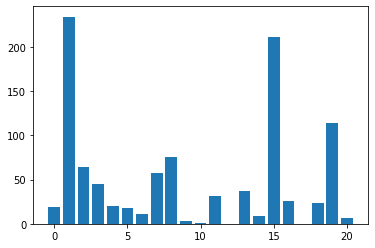

In [321]:
X_train_enc, X_test_enc = prepare_inputs(X_val_fi_tr_v3, X_val_fi_te_v3)
y_train_enc, y_test_enc = prepare_targets(y_val_fi_tr_v3, y_val_fi_te_v3)
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [355]:
X_v3.columns

Index(['petitionerState', 'petitioner', 'respondent', 'respondentState',
       'jurisdiction', 'adminAction', 'adminActionState', 'caseOrigin',
       'caseOriginState', 'caseSource', 'caseSourceState', 'lcDisposition',
       'lcDispositionDirection', 'issueArea', 'lawType', 'certReason',
       'lcDisagreement', 'original', 'month', 'weekday', 'oral_arg'],
      dtype='object')

In [79]:
%%time

mylist = ["caseSource","caseSourceState","original", "lcDispositionDirection", "oral_arg",
         "lawType"]

listthrow = []
list_of_total = []
keys = []
values = []

for L in range(len(mylist) + 1):
    for subset in itertools.combinations(mylist, L):
        listthrow.append(subset)

for throw in listthrow:
    X_v4 = X_v3.drop(list(throw), axis = 1)
    X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(
        X_v4, y_v3, test_size=0.33, stratify=y_v3, random_state=18)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
    list_roc_auc_stratified_train = []
  
    for train_indexes, test_indexes in skf.split(X_train_v4, y_train_v4):
        X_train_fold, X_test_fold = X_train_v4.iloc[train_indexes], X_train_v4.iloc[test_indexes]
        y_train_fold, y_test_fold = y_train_v4.iloc[train_indexes], y_train_v4.iloc[test_indexes]
        model.fit(X_train_fold, y_train_fold)
        roc_auc = roc_auc_score(y_test_fold, model.predict_proba(X_test_fold)[:, 1])
        list_roc_auc_stratified_train.append(roc_auc)

    total = 0
    for elem in list_roc_auc_stratified_train:
        total += elem
    total1 = total /5
    list_of_total.append(total1)
    
    keys.append(throw)
    values.append(total1)
    
item_id = values.index(max(values))
print("Наилучший набор выбрасываемых признаков:" + str(keys[item_id]))
print("Наилучшее значение метрики "+ str(max(values)))

Наилучший набор выбрасываемых признаков:('oral_arg',)
Наилучшее значение метрики 0.6888079972742531
Wall time: 1h 50min 55s


In [31]:
# v3 - датасет со всеми признаками
# v4 - с выброшенными
X_v4 = X_v3.drop(["oral_arg"], axis = 1)

X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(
        X_v4, y_v3, test_size=0.33, stratify=y_v3, random_state=18)
X_train_valid_v4, X_test_valid_v4, y_train_valid_v4, y_test_valid_v4 = train_test_split(
        X_train_v4, y_train_v4, test_size=0.33, stratify=y_train_v4, random_state=18)


Запустим два нижеприведённых фрагмента кода несколько раз чтобы проверить как изменилось качество модели при удалении семи признаков.

In [81]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
list_auc_stratified_train = []
for train_indexes, test_indexes in skf.split(X_train_v4, y_train_v4):
    X_train_fold, X_test_fold = X_train_v4.iloc[train_indexes], X_train_v4.iloc[test_indexes]
    y_train_fold, y_test_fold = y_train_v4.iloc[train_indexes], y_train_v4.iloc[test_indexes]
    rf3.fit(X_train_fold, y_train_fold)
    y_pred = rf3.predict(X_test_fold)
    roc_auc = roc_auc_score(y_test_fold, rf3.predict_proba(X_test_fold)[:, 1])
    list_auc_stratified_train.append(roc_auc)
    total = 0
    for elem in list_auc_stratified_train:
        total += elem
    total1 = total /5
print(total1)

0.6873878750888414


In [45]:
model = RandomForestClassifier(n_estimators = 120, min_samples_split = 5, min_samples_leaf = 1, max_depth =  200, 
                               criterion = 'gini', bootstrap =  False)
fitted = model.fit(X_train_v4, y_train_v4)
y_pred = fitted.predict(X_test_v4)
accuracy_score(y_pred, y_test_v4)

0.677331723513432

In [22]:
tn, fp, fn, tp = confusion_matrix(y_test_v4, y_pred).ravel()

In [23]:
tn, fp, fn, tp

(435, 741, 318, 1819)

In [39]:
roc_auc_score(y_test_v4, model.predict_proba(X_test_v4)[:, 1])

0.6884283310891038